##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, 
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Bangla Article Classification With TF-Hub

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/bangla_article_classifier"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Caution: In addition to installing Python packages with pip, this notebook uses
`sudo apt install` to install system packages: `unzip`.

This Colab is a demonstration of using [Tensorflow Hub](https://www.tensorflow.org/hub/) for text classification in non-English/local languages. Here we choose [Bangla](https://en.wikipedia.org/wiki/Bengali_language) as the local language and use pretrained word embeddings to solve a multiclass classification task where we classify Bangla news articles in 5 categories.  The pretrained embeddings for Bangla comes from [fastText](https://fasttext.cc/docs/en/crawl-vectors.html) which is a library by Facebook with released pretrained word vectors for 157 languages. 

We'll use TF-Hub's pretrained embedding exporter for converting the word embeddings to a text embedding module first and then use the module to train a classifier with [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras), Tensorflow's high level user friendly API to build deep learning models.  Even if we are using fastText embeddings here, it's possible to export any other embeddings pretrained from other tasks and quickly get results with Tensorflow hub. 

## Setup

In [2]:
%%bash
# https://github.com/pypa/setuptools/issues/1694#issuecomment-466010982
pip install gdown --no-use-pep517

In [3]:
%%bash
sudo apt-get install -y unzip

Reading package lists...


Building dependency tree...


Reading state information...


unzip is already the newest version (6.0-25ubuntu1.1).


The following packages were automatically installed and are no longer required:


  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2


  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2


  libparted-fs-resize0 libxmlb2


Use 'sudo apt autoremove' to remove them.


0 upgraded, 0 newly installed, 0 to remove and 126 not upgraded.


In [4]:
import os

import tensorflow as tf
import tensorflow_hub as hub

import gdown
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset

We will use [BARD](https://www.researchgate.net/publication/328214545_BARD_Bangla_Article_Classification_Using_a_New_Comprehensive_Dataset) (Bangla Article Dataset) which has around 376,226 articles collected from different Bangla news portals and labelled with 5 categories: economy, state, international, sports, and entertainment. We download the file from Google Drive this ([bit.ly/BARD_DATASET](https://bit.ly/BARD_DATASET)) link is referring to from [this](https://github.com/tanvirfahim15/BARD-Bangla-Article-Classifier) GitHub repository.


In [5]:
gdown.download(
    url='https://drive.google.com/uc?id=1Ag0jd21oRwJhVFIBohmX_ogeojVtapLy',
    output='bard.zip',
    quiet=True
)

'bard.zip'

In [6]:
%%bash
unzip -qo bard.zip

# Export pretrained word vectors to TF-Hub module

TF-Hub provides some useful scripts for converting word embeddings to TF-hub text embedding modules [here](https://github.com/tensorflow/hub/tree/master/examples/text_embeddings_v2). To make the module for Bangla or any other languages, we simply have to download the word embedding `.txt` or `.vec` file to the same directory as `export_v2.py` and run the script.


The exporter reads the embedding vectors and exports it to a Tensorflow [SavedModel](https://www.tensorflow.org/beta/guide/saved_model). A SavedModel contains a complete TensorFlow program including weights and graph. TF-Hub can load the SavedModel as a [module](https://www.tensorflow.org/hub/api_docs/python/hub/Module), which we will use to build the model for text classification. Since we are using `tf.keras` to build the model, we will use [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer), which provides a wrapper for a TF-Hub module to use as a Keras Layer.

First we will get our word embeddings from fastText and embedding exporter from TF-Hub [repo](https://github.com/tensorflow/hub).


In [7]:
%%bash
curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
curl -O https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py
gunzip -qf cc.bn.300.vec.gz --k

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current


                                 Dload  Upload   Total   Spent    Left  Speed


100  840M  100  840M    0     0  41.8M      0  0:00:20  0:00:20 --:--:-- 42.3M


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current


                                 Dload  Upload   Total   Spent    Left  Speed


100  7500  100  7500    0     0  50675      0 --:--:-- --:--:-- --:--:-- 50675


Then, we will run the exporter script on our embedding file. Since fastText embeddings have a header line and are pretty large (around 3.3 GB for Bangla after converting to a module) we ignore the first line and export only the first 100, 000 tokens to the text embedding module.

In [8]:
%%bash
python export_v2.py --embedding_file=cc.bn.300.vec --export_path=text_module --num_lines_to_ignore=1 --num_lines_to_use=100000

INFO:tensorflow:Assets written to: text_module/assets


I0317 11:10:25.262115 140175947175744 builder_impl.py:797] Assets written to: text_module/assets


In [9]:
module_path = "text_module"
embedding_layer = hub.KerasLayer(module_path, trainable=False)

The text embedding module takes a batch of sentences in a 1D tensor of strings as input and outputs the embedding vectors of shape (batch_size, embedding_dim) corresponding to the sentences. It preprocesses the input by splitting on spaces. Word embeddings are combined to sentence embeddings with the `sqrtn` combiner(See [here](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup_sparse)). For demonstration we pass a list of Bangla words as input and get the corresponding embedding vectors.

In [10]:
embedding_layer(['বাস', 'বসবাস', 'ট্রেন', 'যাত্রী', 'ট্রাক']) 

<tf.Tensor: shape=(5, 300), dtype=float64, numpy=
array([[ 0.0462, -0.0355,  0.0129, ...,  0.0025, -0.0966,  0.0216],
       [-0.0631, -0.0051,  0.085 , ...,  0.0249, -0.0149,  0.0203],
       [ 0.1371, -0.069 , -0.1176, ...,  0.029 ,  0.0508, -0.026 ],
       [ 0.0532, -0.0465, -0.0504, ...,  0.02  , -0.0023,  0.0011],
       [ 0.0908, -0.0404, -0.0536, ..., -0.0275,  0.0528,  0.0253]])>

# Convert to Tensorflow Dataset 


Since the dataset is really large instead of loading the entire dataset in memory we will use a generator to yield samples in run-time in batches using [Tensorflow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) functions. The dataset is also very imbalanced, so, before using the generator, we will shuffle the dataset. 


In [11]:
dir_names = ['economy', 'sports', 'entertainment', 'state', 'international']

file_paths = []
labels = []
for i, dir in enumerate(dir_names):
  file_names = ["/".join([dir, name]) for name in os.listdir(dir)]
  file_paths += file_names
  labels += [i] * len(os.listdir(dir))
  
np.random.seed(42)
permutation = np.random.permutation(len(file_paths))

file_paths = np.array(file_paths)[permutation]
labels = np.array(labels)[permutation]

We can check the distribution of labels in the training and validation examples after shuffling.

In [12]:
train_frac = 0.8
train_size = int(len(file_paths) * train_frac)

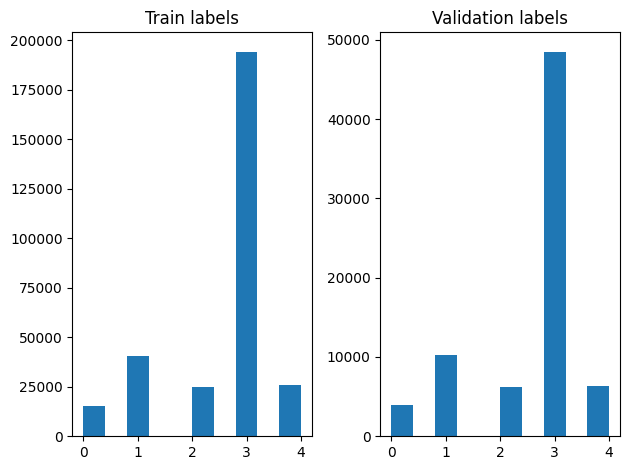

In [13]:
# plot training vs validation distribution
plt.subplot(1, 2, 1)
plt.hist(labels[0:train_size])
plt.title("Train labels")
plt.subplot(1, 2, 2)
plt.hist(labels[train_size:])
plt.title("Validation labels")
plt.tight_layout()

To create a [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) using a generator, we first write a generator function which reads each of the articles from `file_paths` and the labels from the label array, and yields one training example at each step. We pass this generator function to the [`tf.data.Dataset.from_generator`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator) method and specify the output types. Each training example is a tuple containing an article of `tf.string` data type and one-hot encoded label. We split the dataset with a train-validation split of 80-20 using [`tf.data.Dataset.skip`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#skip) and [`tf.data.Dataset.take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) methods.

In [14]:
def load_file(path, label):
    return tf.io.read_file(path), label

In [15]:
def make_datasets(train_size):
  batch_size = 256

  train_files = file_paths[:train_size]
  train_labels = labels[:train_size]
  train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
  train_ds = train_ds.map(load_file).shuffle(5000)
  train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  test_files = file_paths[train_size:]
  test_labels = labels[train_size:]
  test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
  test_ds = test_ds.map(load_file)
  test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


  return train_ds, test_ds

In [16]:
train_data, validation_data = make_datasets(train_size)

# Model Training and Evaluation

Since we have already added a wrapper around our module to use it as any other layer in Keras, we can create a small [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model which is a linear stack of layers. We can add our text embedding module with `model.add` just like any other layer. We compile the model by specifying the loss and optimizer and train it for 10 epochs. The `tf.keras` API can handle Tensorflow Datasets as input, so we can pass a Dataset instance to the fit method for model training. Since we are using the generator function, `tf.data` will handle generating the samples, batching them and feeding them to the model.

## Model

In [17]:
def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype=tf.string),
    embedding_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(5),
  ])
  model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer="adam", metrics=['accuracy'])
  return model

In [18]:
model = create_model()
# Create earlystopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

## Training

In [19]:

history = model.fit(train_data, 
                    validation_data=validation_data, 
                    epochs=5, 
                    callbacks=[early_stopping_callback])

Epoch 1/5


   1/1176 [..............................] - ETA: 1:10:19 - loss: 1.6306 - accuracy: 0.1094

   4/1176 [..............................] - ETA: 24s - loss: 1.5519 - accuracy: 0.3877    

   7/1176 [..............................] - ETA: 22s - loss: 1.4902 - accuracy: 0.5335

  10/1176 [..............................] - ETA: 22s - loss: 1.4324 - accuracy: 0.5887

  13/1176 [..............................] - ETA: 22s - loss: 1.3748 - accuracy: 0.6226

  16/1176 [..............................] - ETA: 21s - loss: 1.3173 - accuracy: 0.6423

  19/1176 [..............................] - ETA: 21s - loss: 1.2627 - accuracy: 0.6546

  22/1176 [..............................] - ETA: 21s - loss: 1.2176 - accuracy: 0.6626

  25/1176 [..............................] - ETA: 21s - loss: 1.1841 - accuracy: 0.6702

  28/1176 [..............................] - ETA: 20s - loss: 1.1464 - accuracy: 0.6777

  31/1176 [..............................] - ETA: 20s - loss: 1.1119 - accuracy: 0.6856

  34/1176 [..............................] - ETA: 20s - loss: 1.0788 - accuracy: 0.6942

  37/1176 [..............................] - ETA: 20s - loss: 1.0458 - accuracy: 0.7026

  40/1176 [>.............................] - ETA: 20s - loss: 1.0172 - accuracy: 0.7084

  43/1176 [>.............................] - ETA: 20s - loss: 0.9931 - accuracy: 0.7133

  46/1176 [>.............................] - ETA: 20s - loss: 0.9724 - accuracy: 0.7169

  49/1176 [>.............................] - ETA: 20s - loss: 0.9483 - accuracy: 0.7231

  52/1176 [>.............................] - ETA: 19s - loss: 0.9272 - accuracy: 0.7277

  54/1176 [>.............................] - ETA: 20s - loss: 0.9175 - accuracy: 0.7291

  58/1176 [>.............................] - ETA: 20s - loss: 0.8944 - accuracy: 0.7337

  61/1176 [>.............................] - ETA: 20s - loss: 0.8755 - accuracy: 0.7389

  64/1176 [>.............................] - ETA: 21s - loss: 0.8606 - accuracy: 0.7424

  65/1176 [>.............................] - ETA: 23s - loss: 0.8549 - accuracy: 0.7438

  67/1176 [>.............................] - ETA: 23s - loss: 0.8453 - accuracy: 0.7458

  71/1176 [>.............................] - ETA: 23s - loss: 0.8243 - accuracy: 0.7506

  74/1176 [>.............................] - ETA: 23s - loss: 0.8092 - accuracy: 0.7539

  77/1176 [>.............................] - ETA: 22s - loss: 0.7958 - accuracy: 0.7569

  80/1176 [=>............................] - ETA: 22s - loss: 0.7831 - accuracy: 0.7596

  84/1176 [=>............................] - ETA: 22s - loss: 0.7655 - accuracy: 0.7647

  88/1176 [=>............................] - ETA: 22s - loss: 0.7502 - accuracy: 0.7688

  92/1176 [=>............................] - ETA: 21s - loss: 0.7355 - accuracy: 0.7729

  95/1176 [=>............................] - ETA: 21s - loss: 0.7242 - accuracy: 0.7762

  98/1176 [=>............................] - ETA: 21s - loss: 0.7134 - accuracy: 0.7795

 101/1176 [=>............................] - ETA: 21s - loss: 0.7019 - accuracy: 0.7829

 105/1176 [=>............................] - ETA: 21s - loss: 0.6884 - accuracy: 0.7869

 108/1176 [=>............................] - ETA: 21s - loss: 0.6780 - accuracy: 0.7900

 111/1176 [=>............................] - ETA: 20s - loss: 0.6689 - accuracy: 0.7927

 114/1176 [=>............................] - ETA: 20s - loss: 0.6593 - accuracy: 0.7958

 117/1176 [=>............................] - ETA: 20s - loss: 0.6511 - accuracy: 0.7981

 121/1176 [==>...........................] - ETA: 20s - loss: 0.6398 - accuracy: 0.8014

 124/1176 [==>...........................] - ETA: 20s - loss: 0.6313 - accuracy: 0.8039

 127/1176 [==>...........................] - ETA: 20s - loss: 0.6230 - accuracy: 0.8064

 130/1176 [==>...........................] - ETA: 20s - loss: 0.6158 - accuracy: 0.8086

 133/1176 [==>...........................] - ETA: 20s - loss: 0.6088 - accuracy: 0.8108

 137/1176 [==>...........................] - ETA: 19s - loss: 0.5988 - accuracy: 0.8140

 141/1176 [==>...........................] - ETA: 19s - loss: 0.5899 - accuracy: 0.8166

 144/1176 [==>...........................] - ETA: 19s - loss: 0.5841 - accuracy: 0.8183

 148/1176 [==>...........................] - ETA: 19s - loss: 0.5749 - accuracy: 0.8213

 151/1176 [==>...........................] - ETA: 19s - loss: 0.5684 - accuracy: 0.8234

 154/1176 [==>...........................] - ETA: 19s - loss: 0.5631 - accuracy: 0.8251

 157/1176 [===>..........................] - ETA: 19s - loss: 0.5566 - accuracy: 0.8270

 160/1176 [===>..........................] - ETA: 19s - loss: 0.5512 - accuracy: 0.8286

 163/1176 [===>..........................] - ETA: 19s - loss: 0.5468 - accuracy: 0.8298

 166/1176 [===>..........................] - ETA: 18s - loss: 0.5423 - accuracy: 0.8310

 169/1176 [===>..........................] - ETA: 18s - loss: 0.5367 - accuracy: 0.8326

 173/1176 [===>..........................] - ETA: 18s - loss: 0.5302 - accuracy: 0.8343

 176/1176 [===>..........................] - ETA: 18s - loss: 0.5259 - accuracy: 0.8356

 180/1176 [===>..........................] - ETA: 18s - loss: 0.5197 - accuracy: 0.8377

 183/1176 [===>..........................] - ETA: 18s - loss: 0.5150 - accuracy: 0.8390

 186/1176 [===>..........................] - ETA: 18s - loss: 0.5108 - accuracy: 0.8405

 190/1176 [===>..........................] - ETA: 18s - loss: 0.5050 - accuracy: 0.8422

 194/1176 [===>..........................] - ETA: 18s - loss: 0.5005 - accuracy: 0.8436

 198/1176 [====>.........................] - ETA: 18s - loss: 0.4949 - accuracy: 0.8455

 201/1176 [====>.........................] - ETA: 17s - loss: 0.4914 - accuracy: 0.8465

 204/1176 [====>.........................] - ETA: 17s - loss: 0.4880 - accuracy: 0.8475

 207/1176 [====>.........................] - ETA: 17s - loss: 0.4840 - accuracy: 0.8487

 211/1176 [====>.........................] - ETA: 17s - loss: 0.4793 - accuracy: 0.8499

 214/1176 [====>.........................] - ETA: 17s - loss: 0.4760 - accuracy: 0.8510

 217/1176 [====>.........................] - ETA: 17s - loss: 0.4723 - accuracy: 0.8522

 220/1176 [====>.........................] - ETA: 17s - loss: 0.4692 - accuracy: 0.8531

 224/1176 [====>.........................] - ETA: 17s - loss: 0.4644 - accuracy: 0.8545

 228/1176 [====>.........................] - ETA: 17s - loss: 0.4602 - accuracy: 0.8559

 231/1176 [====>.........................] - ETA: 17s - loss: 0.4569 - accuracy: 0.8569

 234/1176 [====>.........................] - ETA: 17s - loss: 0.4540 - accuracy: 0.8577

 237/1176 [=====>........................] - ETA: 17s - loss: 0.4511 - accuracy: 0.8584

 240/1176 [=====>........................] - ETA: 17s - loss: 0.4483 - accuracy: 0.8592

 243/1176 [=====>........................] - ETA: 16s - loss: 0.4458 - accuracy: 0.8599

 247/1176 [=====>........................] - ETA: 16s - loss: 0.4422 - accuracy: 0.8610

 250/1176 [=====>........................] - ETA: 16s - loss: 0.4395 - accuracy: 0.8617

 253/1176 [=====>........................] - ETA: 16s - loss: 0.4368 - accuracy: 0.8626

 257/1176 [=====>........................] - ETA: 16s - loss: 0.4332 - accuracy: 0.8637

 261/1176 [=====>........................] - ETA: 16s - loss: 0.4297 - accuracy: 0.8647

 264/1176 [=====>........................] - ETA: 16s - loss: 0.4274 - accuracy: 0.8654

 267/1176 [=====>........................] - ETA: 16s - loss: 0.4245 - accuracy: 0.8663

 271/1176 [=====>........................] - ETA: 16s - loss: 0.4214 - accuracy: 0.8671

 274/1176 [=====>........................] - ETA: 16s - loss: 0.4188 - accuracy: 0.8679

 278/1176 [======>.......................] - ETA: 16s - loss: 0.4158 - accuracy: 0.8688

 282/1176 [======>.......................] - ETA: 16s - loss: 0.4128 - accuracy: 0.8697

 286/1176 [======>.......................] - ETA: 15s - loss: 0.4098 - accuracy: 0.8706

 289/1176 [======>.......................] - ETA: 15s - loss: 0.4077 - accuracy: 0.8712

 292/1176 [======>.......................] - ETA: 15s - loss: 0.4052 - accuracy: 0.8719

 296/1176 [======>.......................] - ETA: 15s - loss: 0.4019 - accuracy: 0.8729

 299/1176 [======>.......................] - ETA: 15s - loss: 0.3996 - accuracy: 0.8736

 303/1176 [======>.......................] - ETA: 15s - loss: 0.3972 - accuracy: 0.8744

 307/1176 [======>.......................] - ETA: 15s - loss: 0.3943 - accuracy: 0.8753

 310/1176 [======>.......................] - ETA: 15s - loss: 0.3920 - accuracy: 0.8759

 314/1176 [=======>......................] - ETA: 15s - loss: 0.3896 - accuracy: 0.8766

 317/1176 [=======>......................] - ETA: 15s - loss: 0.3879 - accuracy: 0.8772

 321/1176 [=======>......................] - ETA: 15s - loss: 0.3859 - accuracy: 0.8776

 325/1176 [=======>......................] - ETA: 15s - loss: 0.3836 - accuracy: 0.8784

 328/1176 [=======>......................] - ETA: 15s - loss: 0.3818 - accuracy: 0.8789

 332/1176 [=======>......................] - ETA: 14s - loss: 0.3796 - accuracy: 0.8794

 335/1176 [=======>......................] - ETA: 14s - loss: 0.3778 - accuracy: 0.8799

 338/1176 [=======>......................] - ETA: 14s - loss: 0.3762 - accuracy: 0.8805

 342/1176 [=======>......................] - ETA: 14s - loss: 0.3737 - accuracy: 0.8813

 346/1176 [=======>......................] - ETA: 14s - loss: 0.3716 - accuracy: 0.8819

 349/1176 [=======>......................] - ETA: 14s - loss: 0.3704 - accuracy: 0.8823

 352/1176 [=======>......................] - ETA: 14s - loss: 0.3691 - accuracy: 0.8827

 355/1176 [========>.....................] - ETA: 14s - loss: 0.3676 - accuracy: 0.8831

 358/1176 [========>.....................] - ETA: 14s - loss: 0.3661 - accuracy: 0.8835

 361/1176 [========>.....................] - ETA: 14s - loss: 0.3647 - accuracy: 0.8839

 365/1176 [========>.....................] - ETA: 14s - loss: 0.3624 - accuracy: 0.8845

 368/1176 [========>.....................] - ETA: 14s - loss: 0.3609 - accuracy: 0.8849

 371/1176 [========>.....................] - ETA: 14s - loss: 0.3595 - accuracy: 0.8853

 374/1176 [========>.....................] - ETA: 14s - loss: 0.3578 - accuracy: 0.8857

 378/1176 [========>.....................] - ETA: 14s - loss: 0.3558 - accuracy: 0.8863

 382/1176 [========>.....................] - ETA: 13s - loss: 0.3540 - accuracy: 0.8868

 385/1176 [========>.....................] - ETA: 13s - loss: 0.3525 - accuracy: 0.8873

 388/1176 [========>.....................] - ETA: 13s - loss: 0.3511 - accuracy: 0.8877

 391/1176 [========>.....................] - ETA: 13s - loss: 0.3499 - accuracy: 0.8880

 395/1176 [=========>....................] - ETA: 13s - loss: 0.3482 - accuracy: 0.8885

 399/1176 [=========>....................] - ETA: 13s - loss: 0.3469 - accuracy: 0.8889

 402/1176 [=========>....................] - ETA: 13s - loss: 0.3460 - accuracy: 0.8892

 406/1176 [=========>....................] - ETA: 13s - loss: 0.3443 - accuracy: 0.8898

 410/1176 [=========>....................] - ETA: 13s - loss: 0.3429 - accuracy: 0.8903

 413/1176 [=========>....................] - ETA: 13s - loss: 0.3416 - accuracy: 0.8907

 416/1176 [=========>....................] - ETA: 13s - loss: 0.3408 - accuracy: 0.8910

 419/1176 [=========>....................] - ETA: 13s - loss: 0.3397 - accuracy: 0.8913

 423/1176 [=========>....................] - ETA: 13s - loss: 0.3383 - accuracy: 0.8917

 427/1176 [=========>....................] - ETA: 13s - loss: 0.3368 - accuracy: 0.8922

 430/1176 [=========>....................] - ETA: 13s - loss: 0.3357 - accuracy: 0.8925

 434/1176 [==========>...................] - ETA: 13s - loss: 0.3341 - accuracy: 0.8929

 437/1176 [==========>...................] - ETA: 12s - loss: 0.3331 - accuracy: 0.8932

 441/1176 [==========>...................] - ETA: 12s - loss: 0.3314 - accuracy: 0.8936

 444/1176 [==========>...................] - ETA: 12s - loss: 0.3305 - accuracy: 0.8940

 448/1176 [==========>...................] - ETA: 12s - loss: 0.3291 - accuracy: 0.8944

 452/1176 [==========>...................] - ETA: 12s - loss: 0.3275 - accuracy: 0.8949

 456/1176 [==========>...................] - ETA: 12s - loss: 0.3258 - accuracy: 0.8955

 460/1176 [==========>...................] - ETA: 12s - loss: 0.3243 - accuracy: 0.8959

 464/1176 [==========>...................] - ETA: 12s - loss: 0.3230 - accuracy: 0.8963

 467/1176 [==========>...................] - ETA: 12s - loss: 0.3219 - accuracy: 0.8967

 471/1176 [===========>..................] - ETA: 12s - loss: 0.3208 - accuracy: 0.8969

 475/1176 [===========>..................] - ETA: 12s - loss: 0.3196 - accuracy: 0.8973

 478/1176 [===========>..................] - ETA: 12s - loss: 0.3187 - accuracy: 0.8976

 481/1176 [===========>..................] - ETA: 12s - loss: 0.3178 - accuracy: 0.8979

 484/1176 [===========>..................] - ETA: 12s - loss: 0.3167 - accuracy: 0.8982

 487/1176 [===========>..................] - ETA: 12s - loss: 0.3156 - accuracy: 0.8986

 491/1176 [===========>..................] - ETA: 11s - loss: 0.3144 - accuracy: 0.8990

 495/1176 [===========>..................] - ETA: 11s - loss: 0.3134 - accuracy: 0.8993

 499/1176 [===========>..................] - ETA: 11s - loss: 0.3125 - accuracy: 0.8996

 502/1176 [===========>..................] - ETA: 11s - loss: 0.3118 - accuracy: 0.8999

 505/1176 [===========>..................] - ETA: 11s - loss: 0.3109 - accuracy: 0.9001

 508/1176 [===========>..................] - ETA: 11s - loss: 0.3101 - accuracy: 0.9004

 511/1176 [============>.................] - ETA: 11s - loss: 0.3093 - accuracy: 0.9007

 514/1176 [============>.................] - ETA: 11s - loss: 0.3085 - accuracy: 0.9010

 517/1176 [============>.................] - ETA: 11s - loss: 0.3076 - accuracy: 0.9012

 521/1176 [============>.................] - ETA: 11s - loss: 0.3066 - accuracy: 0.9015

 525/1176 [============>.................] - ETA: 11s - loss: 0.3055 - accuracy: 0.9019

 529/1176 [============>.................] - ETA: 11s - loss: 0.3045 - accuracy: 0.9021

 532/1176 [============>.................] - ETA: 11s - loss: 0.3038 - accuracy: 0.9024

 536/1176 [============>.................] - ETA: 11s - loss: 0.3030 - accuracy: 0.9027

 539/1176 [============>.................] - ETA: 11s - loss: 0.3022 - accuracy: 0.9029

 543/1176 [============>.................] - ETA: 10s - loss: 0.3012 - accuracy: 0.9032

 546/1176 [============>.................] - ETA: 10s - loss: 0.3004 - accuracy: 0.9034

 550/1176 [=============>................] - ETA: 10s - loss: 0.2995 - accuracy: 0.9037

 553/1176 [=============>................] - ETA: 10s - loss: 0.2986 - accuracy: 0.9040

 556/1176 [=============>................] - ETA: 10s - loss: 0.2981 - accuracy: 0.9041

 559/1176 [=============>................] - ETA: 10s - loss: 0.2974 - accuracy: 0.9043

 562/1176 [=============>................] - ETA: 10s - loss: 0.2968 - accuracy: 0.9045

 565/1176 [=============>................] - ETA: 10s - loss: 0.2959 - accuracy: 0.9048

 569/1176 [=============>................] - ETA: 10s - loss: 0.2949 - accuracy: 0.9051

 573/1176 [=============>................] - ETA: 10s - loss: 0.2943 - accuracy: 0.9053

 577/1176 [=============>................] - ETA: 10s - loss: 0.2934 - accuracy: 0.9056

 580/1176 [=============>................] - ETA: 10s - loss: 0.2927 - accuracy: 0.9058

 583/1176 [=============>................] - ETA: 10s - loss: 0.2920 - accuracy: 0.9060

 586/1176 [=============>................] - ETA: 10s - loss: 0.2914 - accuracy: 0.9062

 590/1176 [==============>...............] - ETA: 10s - loss: 0.2905 - accuracy: 0.9064

 593/1176 [==============>...............] - ETA: 10s - loss: 0.2898 - accuracy: 0.9067

 596/1176 [==============>...............] - ETA: 10s - loss: 0.2893 - accuracy: 0.9069

 599/1176 [==============>...............] - ETA: 9s - loss: 0.2888 - accuracy: 0.9070 

 603/1176 [==============>...............] - ETA: 9s - loss: 0.2880 - accuracy: 0.9072

 607/1176 [==============>...............] - ETA: 9s - loss: 0.2873 - accuracy: 0.9075

 611/1176 [==============>...............] - ETA: 9s - loss: 0.2865 - accuracy: 0.9077

 614/1176 [==============>...............] - ETA: 9s - loss: 0.2860 - accuracy: 0.9079

 617/1176 [==============>...............] - ETA: 9s - loss: 0.2855 - accuracy: 0.9081

 620/1176 [==============>...............] - ETA: 9s - loss: 0.2849 - accuracy: 0.9083

 623/1176 [==============>...............] - ETA: 9s - loss: 0.2844 - accuracy: 0.9085

 627/1176 [==============>...............] - ETA: 9s - loss: 0.2837 - accuracy: 0.9087

 630/1176 [===============>..............] - ETA: 9s - loss: 0.2831 - accuracy: 0.9089

 634/1176 [===============>..............] - ETA: 9s - loss: 0.2825 - accuracy: 0.9091

 637/1176 [===============>..............] - ETA: 9s - loss: 0.2820 - accuracy: 0.9093

 640/1176 [===============>..............] - ETA: 9s - loss: 0.2816 - accuracy: 0.9094

 644/1176 [===============>..............] - ETA: 9s - loss: 0.2808 - accuracy: 0.9096

 647/1176 [===============>..............] - ETA: 9s - loss: 0.2803 - accuracy: 0.9098

 650/1176 [===============>..............] - ETA: 9s - loss: 0.2798 - accuracy: 0.9099

 653/1176 [===============>..............] - ETA: 9s - loss: 0.2792 - accuracy: 0.9101

 657/1176 [===============>..............] - ETA: 8s - loss: 0.2787 - accuracy: 0.9103

 660/1176 [===============>..............] - ETA: 8s - loss: 0.2781 - accuracy: 0.9104

 663/1176 [===============>..............] - ETA: 8s - loss: 0.2775 - accuracy: 0.9106

 666/1176 [===============>..............] - ETA: 8s - loss: 0.2772 - accuracy: 0.9107

 670/1176 [================>.............] - ETA: 8s - loss: 0.2767 - accuracy: 0.9108

 673/1176 [================>.............] - ETA: 8s - loss: 0.2761 - accuracy: 0.9110

 676/1176 [================>.............] - ETA: 8s - loss: 0.2757 - accuracy: 0.9111

 679/1176 [================>.............] - ETA: 8s - loss: 0.2753 - accuracy: 0.9112

 683/1176 [================>.............] - ETA: 8s - loss: 0.2746 - accuracy: 0.9115

 687/1176 [================>.............] - ETA: 8s - loss: 0.2740 - accuracy: 0.9116

 691/1176 [================>.............] - ETA: 8s - loss: 0.2734 - accuracy: 0.9118

 694/1176 [================>.............] - ETA: 8s - loss: 0.2729 - accuracy: 0.9119

 697/1176 [================>.............] - ETA: 8s - loss: 0.2724 - accuracy: 0.9120

 700/1176 [================>.............] - ETA: 8s - loss: 0.2720 - accuracy: 0.9121

 704/1176 [================>.............] - ETA: 8s - loss: 0.2714 - accuracy: 0.9123

 707/1176 [=================>............] - ETA: 8s - loss: 0.2709 - accuracy: 0.9124

 711/1176 [=================>............] - ETA: 8s - loss: 0.2704 - accuracy: 0.9126

 715/1176 [=================>............] - ETA: 7s - loss: 0.2697 - accuracy: 0.9128

 718/1176 [=================>............] - ETA: 7s - loss: 0.2692 - accuracy: 0.9129

 722/1176 [=================>............] - ETA: 7s - loss: 0.2685 - accuracy: 0.9131

 726/1176 [=================>............] - ETA: 7s - loss: 0.2680 - accuracy: 0.9133

 730/1176 [=================>............] - ETA: 7s - loss: 0.2675 - accuracy: 0.9135

 733/1176 [=================>............] - ETA: 7s - loss: 0.2671 - accuracy: 0.9136

 736/1176 [=================>............] - ETA: 7s - loss: 0.2668 - accuracy: 0.9137

 739/1176 [=================>............] - ETA: 7s - loss: 0.2664 - accuracy: 0.9138

 742/1176 [=================>............] - ETA: 7s - loss: 0.2662 - accuracy: 0.9139

 745/1176 [==================>...........] - ETA: 7s - loss: 0.2658 - accuracy: 0.9141

 748/1176 [==================>...........] - ETA: 7s - loss: 0.2653 - accuracy: 0.9142

 751/1176 [==================>...........] - ETA: 7s - loss: 0.2648 - accuracy: 0.9143

 755/1176 [==================>...........] - ETA: 7s - loss: 0.2642 - accuracy: 0.9146

 758/1176 [==================>...........] - ETA: 7s - loss: 0.2640 - accuracy: 0.9147

 761/1176 [==================>...........] - ETA: 7s - loss: 0.2635 - accuracy: 0.9148

 764/1176 [==================>...........] - ETA: 7s - loss: 0.2632 - accuracy: 0.9149

 767/1176 [==================>...........] - ETA: 7s - loss: 0.2629 - accuracy: 0.9150

 770/1176 [==================>...........] - ETA: 6s - loss: 0.2626 - accuracy: 0.9150

 774/1176 [==================>...........] - ETA: 6s - loss: 0.2620 - accuracy: 0.9151

 777/1176 [==================>...........] - ETA: 6s - loss: 0.2617 - accuracy: 0.9152

 781/1176 [==================>...........] - ETA: 6s - loss: 0.2611 - accuracy: 0.9154

 785/1176 [===================>..........] - ETA: 6s - loss: 0.2605 - accuracy: 0.9156

 789/1176 [===================>..........] - ETA: 6s - loss: 0.2599 - accuracy: 0.9158

 792/1176 [===================>..........] - ETA: 6s - loss: 0.2595 - accuracy: 0.9159

 796/1176 [===================>..........] - ETA: 6s - loss: 0.2590 - accuracy: 0.9161

 800/1176 [===================>..........] - ETA: 6s - loss: 0.2585 - accuracy: 0.9162

 804/1176 [===================>..........] - ETA: 6s - loss: 0.2582 - accuracy: 0.9163

 808/1176 [===================>..........] - ETA: 6s - loss: 0.2578 - accuracy: 0.9164

 811/1176 [===================>..........] - ETA: 6s - loss: 0.2573 - accuracy: 0.9165

 815/1176 [===================>..........] - ETA: 6s - loss: 0.2567 - accuracy: 0.9167

 818/1176 [===================>..........] - ETA: 6s - loss: 0.2565 - accuracy: 0.9168

 821/1176 [===================>..........] - ETA: 6s - loss: 0.2562 - accuracy: 0.9168

 824/1176 [====================>.........] - ETA: 6s - loss: 0.2557 - accuracy: 0.9169

 828/1176 [====================>.........] - ETA: 5s - loss: 0.2551 - accuracy: 0.9171

 832/1176 [====================>.........] - ETA: 5s - loss: 0.2546 - accuracy: 0.9173

 835/1176 [====================>.........] - ETA: 5s - loss: 0.2543 - accuracy: 0.9174

 839/1176 [====================>.........] - ETA: 5s - loss: 0.2538 - accuracy: 0.9176

 843/1176 [====================>.........] - ETA: 5s - loss: 0.2535 - accuracy: 0.9177

 847/1176 [====================>.........] - ETA: 5s - loss: 0.2531 - accuracy: 0.9178

 850/1176 [====================>.........] - ETA: 5s - loss: 0.2527 - accuracy: 0.9180

 853/1176 [====================>.........] - ETA: 5s - loss: 0.2523 - accuracy: 0.9180

 856/1176 [====================>.........] - ETA: 5s - loss: 0.2519 - accuracy: 0.9181

 860/1176 [====================>.........] - ETA: 5s - loss: 0.2515 - accuracy: 0.9182

 864/1176 [=====================>........] - ETA: 5s - loss: 0.2511 - accuracy: 0.9184

 868/1176 [=====================>........] - ETA: 5s - loss: 0.2507 - accuracy: 0.9185

 872/1176 [=====================>........] - ETA: 5s - loss: 0.2502 - accuracy: 0.9186

 875/1176 [=====================>........] - ETA: 5s - loss: 0.2500 - accuracy: 0.9187

 878/1176 [=====================>........] - ETA: 5s - loss: 0.2497 - accuracy: 0.9188

 881/1176 [=====================>........] - ETA: 5s - loss: 0.2494 - accuracy: 0.9189

 884/1176 [=====================>........] - ETA: 5s - loss: 0.2491 - accuracy: 0.9189

 888/1176 [=====================>........] - ETA: 4s - loss: 0.2487 - accuracy: 0.9191

 891/1176 [=====================>........] - ETA: 4s - loss: 0.2483 - accuracy: 0.9191

 895/1176 [=====================>........] - ETA: 4s - loss: 0.2479 - accuracy: 0.9192

 899/1176 [=====================>........] - ETA: 4s - loss: 0.2476 - accuracy: 0.9193

 902/1176 [======================>.......] - ETA: 4s - loss: 0.2473 - accuracy: 0.9194

 906/1176 [======================>.......] - ETA: 4s - loss: 0.2469 - accuracy: 0.9195

 909/1176 [======================>.......] - ETA: 4s - loss: 0.2465 - accuracy: 0.9197

 913/1176 [======================>.......] - ETA: 4s - loss: 0.2463 - accuracy: 0.9197

 917/1176 [======================>.......] - ETA: 4s - loss: 0.2459 - accuracy: 0.9198

 920/1176 [======================>.......] - ETA: 4s - loss: 0.2456 - accuracy: 0.9199

 924/1176 [======================>.......] - ETA: 4s - loss: 0.2453 - accuracy: 0.9200

 928/1176 [======================>.......] - ETA: 4s - loss: 0.2450 - accuracy: 0.9201

 931/1176 [======================>.......] - ETA: 4s - loss: 0.2446 - accuracy: 0.9202

 934/1176 [======================>.......] - ETA: 4s - loss: 0.2444 - accuracy: 0.9203

 938/1176 [======================>.......] - ETA: 4s - loss: 0.2440 - accuracy: 0.9204

 941/1176 [=======================>......] - ETA: 4s - loss: 0.2437 - accuracy: 0.9205

 945/1176 [=======================>......] - ETA: 3s - loss: 0.2434 - accuracy: 0.9206

 948/1176 [=======================>......] - ETA: 3s - loss: 0.2432 - accuracy: 0.9206

 951/1176 [=======================>......] - ETA: 3s - loss: 0.2430 - accuracy: 0.9207

 954/1176 [=======================>......] - ETA: 3s - loss: 0.2426 - accuracy: 0.9208

 958/1176 [=======================>......] - ETA: 3s - loss: 0.2423 - accuracy: 0.9209

 962/1176 [=======================>......] - ETA: 3s - loss: 0.2418 - accuracy: 0.9210

 965/1176 [=======================>......] - ETA: 3s - loss: 0.2416 - accuracy: 0.9211

 968/1176 [=======================>......] - ETA: 3s - loss: 0.2413 - accuracy: 0.9212

 971/1176 [=======================>......] - ETA: 3s - loss: 0.2411 - accuracy: 0.9212

 974/1176 [=======================>......] - ETA: 3s - loss: 0.2409 - accuracy: 0.9213

 978/1176 [=======================>......] - ETA: 3s - loss: 0.2405 - accuracy: 0.9214

 981/1176 [========================>.....] - ETA: 3s - loss: 0.2403 - accuracy: 0.9214

 984/1176 [========================>.....] - ETA: 3s - loss: 0.2400 - accuracy: 0.9215

 987/1176 [========================>.....] - ETA: 3s - loss: 0.2398 - accuracy: 0.9216

 990/1176 [========================>.....] - ETA: 3s - loss: 0.2395 - accuracy: 0.9216

 993/1176 [========================>.....] - ETA: 3s - loss: 0.2392 - accuracy: 0.9217

 997/1176 [========================>.....] - ETA: 3s - loss: 0.2389 - accuracy: 0.9218

1000/1176 [========================>.....] - ETA: 3s - loss: 0.2385 - accuracy: 0.9219

1004/1176 [========================>.....] - ETA: 2s - loss: 0.2382 - accuracy: 0.9220

1007/1176 [========================>.....] - ETA: 2s - loss: 0.2380 - accuracy: 0.9220

1011/1176 [========================>.....] - ETA: 2s - loss: 0.2376 - accuracy: 0.9222

1014/1176 [========================>.....] - ETA: 2s - loss: 0.2374 - accuracy: 0.9222

1018/1176 [========================>.....] - ETA: 2s - loss: 0.2370 - accuracy: 0.9223

1021/1176 [=========================>....] - ETA: 2s - loss: 0.2368 - accuracy: 0.9223

1024/1176 [=========================>....] - ETA: 2s - loss: 0.2366 - accuracy: 0.9224

1028/1176 [=========================>....] - ETA: 2s - loss: 0.2362 - accuracy: 0.9225

1031/1176 [=========================>....] - ETA: 2s - loss: 0.2359 - accuracy: 0.9226

1034/1176 [=========================>....] - ETA: 2s - loss: 0.2357 - accuracy: 0.9226

1038/1176 [=========================>....] - ETA: 2s - loss: 0.2354 - accuracy: 0.9227

1042/1176 [=========================>....] - ETA: 2s - loss: 0.2350 - accuracy: 0.9228

1045/1176 [=========================>....] - ETA: 2s - loss: 0.2348 - accuracy: 0.9230

1048/1176 [=========================>....] - ETA: 2s - loss: 0.2345 - accuracy: 0.9231

1051/1176 [=========================>....] - ETA: 2s - loss: 0.2343 - accuracy: 0.9232

1054/1176 [=========================>....] - ETA: 2s - loss: 0.2341 - accuracy: 0.9232

1058/1176 [=========================>....] - ETA: 2s - loss: 0.2337 - accuracy: 0.9233

1062/1176 [==========================>...] - ETA: 1s - loss: 0.2334 - accuracy: 0.9234

1065/1176 [==========================>...] - ETA: 1s - loss: 0.2331 - accuracy: 0.9235

1068/1176 [==========================>...] - ETA: 1s - loss: 0.2329 - accuracy: 0.9236

1071/1176 [==========================>...] - ETA: 1s - loss: 0.2326 - accuracy: 0.9237

1074/1176 [==========================>...] - ETA: 1s - loss: 0.2324 - accuracy: 0.9237

1077/1176 [==========================>...] - ETA: 1s - loss: 0.2323 - accuracy: 0.9238

1080/1176 [==========================>...] - ETA: 1s - loss: 0.2321 - accuracy: 0.9239

1083/1176 [==========================>...] - ETA: 1s - loss: 0.2318 - accuracy: 0.9239

1087/1176 [==========================>...] - ETA: 1s - loss: 0.2315 - accuracy: 0.9240

1091/1176 [==========================>...] - ETA: 1s - loss: 0.2312 - accuracy: 0.9241

1095/1176 [==========================>...] - ETA: 1s - loss: 0.2311 - accuracy: 0.9241

1098/1176 [===========================>..] - ETA: 1s - loss: 0.2308 - accuracy: 0.9242

1102/1176 [===========================>..] - ETA: 1s - loss: 0.2305 - accuracy: 0.9243

1106/1176 [===========================>..] - ETA: 1s - loss: 0.2303 - accuracy: 0.9244

1109/1176 [===========================>..] - ETA: 1s - loss: 0.2301 - accuracy: 0.9244

1112/1176 [===========================>..] - ETA: 1s - loss: 0.2299 - accuracy: 0.9245

1115/1176 [===========================>..] - ETA: 1s - loss: 0.2296 - accuracy: 0.9246

1119/1176 [===========================>..] - ETA: 0s - loss: 0.2293 - accuracy: 0.9247

1122/1176 [===========================>..] - ETA: 0s - loss: 0.2291 - accuracy: 0.9248

1126/1176 [===========================>..] - ETA: 0s - loss: 0.2288 - accuracy: 0.9248

1129/1176 [===========================>..] - ETA: 0s - loss: 0.2285 - accuracy: 0.9249

1132/1176 [===========================>..] - ETA: 0s - loss: 0.2283 - accuracy: 0.9250

1136/1176 [===========================>..] - ETA: 0s - loss: 0.2280 - accuracy: 0.9250

1140/1176 [============================>.] - ETA: 0s - loss: 0.2277 - accuracy: 0.9251

1144/1176 [============================>.] - ETA: 0s - loss: 0.2274 - accuracy: 0.9252

1148/1176 [============================>.] - ETA: 0s - loss: 0.2271 - accuracy: 0.9253

1151/1176 [============================>.] - ETA: 0s - loss: 0.2269 - accuracy: 0.9253

1155/1176 [============================>.] - ETA: 0s - loss: 0.2266 - accuracy: 0.9254

1159/1176 [============================>.] - ETA: 0s - loss: 0.2264 - accuracy: 0.9255

1163/1176 [============================>.] - ETA: 0s - loss: 0.2262 - accuracy: 0.9255

1167/1176 [============================>.] - ETA: 0s - loss: 0.2260 - accuracy: 0.9256

1171/1176 [============================>.] - ETA: 0s - loss: 0.2257 - accuracy: 0.9256

1175/1176 [============================>.] - ETA: 0s - loss: 0.2256 - accuracy: 0.9257

1176/1176 [==============================] - 28s 21ms/step - loss: 0.2255 - accuracy: 0.9257 - val_loss: 0.1532 - val_accuracy: 0.9480


Epoch 2/5


   1/1176 [..............................] - ETA: 1:33 - loss: 0.1196 - accuracy: 0.9609

   4/1176 [..............................] - ETA: 19s - loss: 0.1332 - accuracy: 0.9609 

   7/1176 [..............................] - ETA: 19s - loss: 0.1350 - accuracy: 0.9576

  11/1176 [..............................] - ETA: 19s - loss: 0.1421 - accuracy: 0.9560

  14/1176 [..............................] - ETA: 19s - loss: 0.1431 - accuracy: 0.9542

  17/1176 [..............................] - ETA: 19s - loss: 0.1496 - accuracy: 0.9504

  21/1176 [..............................] - ETA: 19s - loss: 0.1509 - accuracy: 0.9481

  25/1176 [..............................] - ETA: 19s - loss: 0.1487 - accuracy: 0.9495

  28/1176 [..............................] - ETA: 19s - loss: 0.1482 - accuracy: 0.9506

  31/1176 [..............................] - ETA: 19s - loss: 0.1500 - accuracy: 0.9496

  34/1176 [..............................] - ETA: 19s - loss: 0.1534 - accuracy: 0.9491

  38/1176 [..............................] - ETA: 19s - loss: 0.1540 - accuracy: 0.9482

  42/1176 [>.............................] - ETA: 18s - loss: 0.1542 - accuracy: 0.9480

  45/1176 [>.............................] - ETA: 18s - loss: 0.1528 - accuracy: 0.9485

  48/1176 [>.............................] - ETA: 18s - loss: 0.1529 - accuracy: 0.9485

  51/1176 [>.............................] - ETA: 18s - loss: 0.1504 - accuracy: 0.9493

  54/1176 [>.............................] - ETA: 18s - loss: 0.1499 - accuracy: 0.9490

  57/1176 [>.............................] - ETA: 18s - loss: 0.1498 - accuracy: 0.9488

  60/1176 [>.............................] - ETA: 18s - loss: 0.1507 - accuracy: 0.9486

  63/1176 [>.............................] - ETA: 18s - loss: 0.1509 - accuracy: 0.9485

  66/1176 [>.............................] - ETA: 18s - loss: 0.1509 - accuracy: 0.9482

  70/1176 [>.............................] - ETA: 18s - loss: 0.1491 - accuracy: 0.9489

  73/1176 [>.............................] - ETA: 18s - loss: 0.1506 - accuracy: 0.9482

  77/1176 [>.............................] - ETA: 18s - loss: 0.1512 - accuracy: 0.9483

  80/1176 [=>............................] - ETA: 18s - loss: 0.1499 - accuracy: 0.9487

  84/1176 [=>............................] - ETA: 18s - loss: 0.1503 - accuracy: 0.9485

  87/1176 [=>............................] - ETA: 18s - loss: 0.1503 - accuracy: 0.9482

  90/1176 [=>............................] - ETA: 18s - loss: 0.1508 - accuracy: 0.9477

  93/1176 [=>............................] - ETA: 18s - loss: 0.1499 - accuracy: 0.9480

  97/1176 [=>............................] - ETA: 18s - loss: 0.1487 - accuracy: 0.9484

 101/1176 [=>............................] - ETA: 18s - loss: 0.1492 - accuracy: 0.9483

 104/1176 [=>............................] - ETA: 18s - loss: 0.1485 - accuracy: 0.9486

 108/1176 [=>............................] - ETA: 17s - loss: 0.1487 - accuracy: 0.9484

 111/1176 [=>............................] - ETA: 17s - loss: 0.1485 - accuracy: 0.9482

 114/1176 [=>............................] - ETA: 17s - loss: 0.1483 - accuracy: 0.9482

 118/1176 [==>...........................] - ETA: 17s - loss: 0.1481 - accuracy: 0.9481

 122/1176 [==>...........................] - ETA: 17s - loss: 0.1478 - accuracy: 0.9481

 126/1176 [==>...........................] - ETA: 17s - loss: 0.1471 - accuracy: 0.9483

 130/1176 [==>...........................] - ETA: 17s - loss: 0.1474 - accuracy: 0.9482

 134/1176 [==>...........................] - ETA: 17s - loss: 0.1480 - accuracy: 0.9481

 138/1176 [==>...........................] - ETA: 17s - loss: 0.1478 - accuracy: 0.9481

 141/1176 [==>...........................] - ETA: 17s - loss: 0.1474 - accuracy: 0.9482

 144/1176 [==>...........................] - ETA: 17s - loss: 0.1482 - accuracy: 0.9481

 148/1176 [==>...........................] - ETA: 17s - loss: 0.1482 - accuracy: 0.9481

 151/1176 [==>...........................] - ETA: 17s - loss: 0.1482 - accuracy: 0.9481

 154/1176 [==>...........................] - ETA: 17s - loss: 0.1476 - accuracy: 0.9482

 157/1176 [===>..........................] - ETA: 17s - loss: 0.1475 - accuracy: 0.9481

 161/1176 [===>..........................] - ETA: 16s - loss: 0.1470 - accuracy: 0.9482

 165/1176 [===>..........................] - ETA: 16s - loss: 0.1469 - accuracy: 0.9485

 168/1176 [===>..........................] - ETA: 16s - loss: 0.1468 - accuracy: 0.9484

 171/1176 [===>..........................] - ETA: 16s - loss: 0.1466 - accuracy: 0.9486

 175/1176 [===>..........................] - ETA: 16s - loss: 0.1470 - accuracy: 0.9485

 179/1176 [===>..........................] - ETA: 16s - loss: 0.1471 - accuracy: 0.9485

 183/1176 [===>..........................] - ETA: 16s - loss: 0.1473 - accuracy: 0.9484

 187/1176 [===>..........................] - ETA: 16s - loss: 0.1478 - accuracy: 0.9483

 191/1176 [===>..........................] - ETA: 16s - loss: 0.1479 - accuracy: 0.9482

 195/1176 [===>..........................] - ETA: 16s - loss: 0.1477 - accuracy: 0.9484

 199/1176 [====>.........................] - ETA: 16s - loss: 0.1482 - accuracy: 0.9484

 202/1176 [====>.........................] - ETA: 16s - loss: 0.1487 - accuracy: 0.9483

 205/1176 [====>.........................] - ETA: 16s - loss: 0.1486 - accuracy: 0.9483

 208/1176 [====>.........................] - ETA: 16s - loss: 0.1488 - accuracy: 0.9484

 212/1176 [====>.........................] - ETA: 16s - loss: 0.1487 - accuracy: 0.9484

 216/1176 [====>.........................] - ETA: 15s - loss: 0.1489 - accuracy: 0.9485

 219/1176 [====>.........................] - ETA: 15s - loss: 0.1489 - accuracy: 0.9484

 223/1176 [====>.........................] - ETA: 15s - loss: 0.1491 - accuracy: 0.9483

 226/1176 [====>.........................] - ETA: 15s - loss: 0.1494 - accuracy: 0.9482

 229/1176 [====>.........................] - ETA: 15s - loss: 0.1495 - accuracy: 0.9481

 233/1176 [====>.........................] - ETA: 15s - loss: 0.1494 - accuracy: 0.9482

 237/1176 [=====>........................] - ETA: 15s - loss: 0.1492 - accuracy: 0.9482

 241/1176 [=====>........................] - ETA: 15s - loss: 0.1491 - accuracy: 0.9483

 245/1176 [=====>........................] - ETA: 15s - loss: 0.1491 - accuracy: 0.9483

 249/1176 [=====>........................] - ETA: 15s - loss: 0.1494 - accuracy: 0.9481

 252/1176 [=====>........................] - ETA: 15s - loss: 0.1493 - accuracy: 0.9481

 255/1176 [=====>........................] - ETA: 15s - loss: 0.1491 - accuracy: 0.9482

 259/1176 [=====>........................] - ETA: 15s - loss: 0.1490 - accuracy: 0.9482

 262/1176 [=====>........................] - ETA: 15s - loss: 0.1489 - accuracy: 0.9481

 266/1176 [=====>........................] - ETA: 15s - loss: 0.1495 - accuracy: 0.9478

 269/1176 [=====>........................] - ETA: 15s - loss: 0.1496 - accuracy: 0.9478

 273/1176 [=====>........................] - ETA: 14s - loss: 0.1499 - accuracy: 0.9476

 276/1176 [======>.......................] - ETA: 14s - loss: 0.1497 - accuracy: 0.9477

 280/1176 [======>.......................] - ETA: 14s - loss: 0.1494 - accuracy: 0.9477

 283/1176 [======>.......................] - ETA: 14s - loss: 0.1495 - accuracy: 0.9477

 287/1176 [======>.......................] - ETA: 14s - loss: 0.1497 - accuracy: 0.9476

 291/1176 [======>.......................] - ETA: 14s - loss: 0.1497 - accuracy: 0.9475

 294/1176 [======>.......................] - ETA: 14s - loss: 0.1495 - accuracy: 0.9476

 298/1176 [======>.......................] - ETA: 14s - loss: 0.1492 - accuracy: 0.9477

 301/1176 [======>.......................] - ETA: 14s - loss: 0.1492 - accuracy: 0.9477

 304/1176 [======>.......................] - ETA: 14s - loss: 0.1489 - accuracy: 0.9478

 308/1176 [======>.......................] - ETA: 14s - loss: 0.1490 - accuracy: 0.9478

 311/1176 [======>.......................] - ETA: 14s - loss: 0.1489 - accuracy: 0.9479

 315/1176 [=======>......................] - ETA: 14s - loss: 0.1491 - accuracy: 0.9478

 319/1176 [=======>......................] - ETA: 14s - loss: 0.1488 - accuracy: 0.9480

 322/1176 [=======>......................] - ETA: 14s - loss: 0.1488 - accuracy: 0.9479

 325/1176 [=======>......................] - ETA: 14s - loss: 0.1486 - accuracy: 0.9480

 329/1176 [=======>......................] - ETA: 14s - loss: 0.1485 - accuracy: 0.9480

 332/1176 [=======>......................] - ETA: 14s - loss: 0.1484 - accuracy: 0.9480

 335/1176 [=======>......................] - ETA: 13s - loss: 0.1484 - accuracy: 0.9480

 339/1176 [=======>......................] - ETA: 13s - loss: 0.1483 - accuracy: 0.9481

 342/1176 [=======>......................] - ETA: 13s - loss: 0.1482 - accuracy: 0.9481

 346/1176 [=======>......................] - ETA: 13s - loss: 0.1482 - accuracy: 0.9481

 349/1176 [=======>......................] - ETA: 13s - loss: 0.1484 - accuracy: 0.9480

 353/1176 [========>.....................] - ETA: 13s - loss: 0.1480 - accuracy: 0.9481

 357/1176 [========>.....................] - ETA: 13s - loss: 0.1477 - accuracy: 0.9482

 361/1176 [========>.....................] - ETA: 13s - loss: 0.1477 - accuracy: 0.9482

 364/1176 [========>.....................] - ETA: 13s - loss: 0.1473 - accuracy: 0.9484

 367/1176 [========>.....................] - ETA: 13s - loss: 0.1476 - accuracy: 0.9483

 371/1176 [========>.....................] - ETA: 13s - loss: 0.1474 - accuracy: 0.9484

 375/1176 [========>.....................] - ETA: 13s - loss: 0.1473 - accuracy: 0.9485

 378/1176 [========>.....................] - ETA: 13s - loss: 0.1473 - accuracy: 0.9486

 382/1176 [========>.....................] - ETA: 13s - loss: 0.1473 - accuracy: 0.9486

 386/1176 [========>.....................] - ETA: 13s - loss: 0.1472 - accuracy: 0.9486

 389/1176 [========>.....................] - ETA: 13s - loss: 0.1470 - accuracy: 0.9487

 392/1176 [=========>....................] - ETA: 13s - loss: 0.1472 - accuracy: 0.9487

 396/1176 [=========>....................] - ETA: 12s - loss: 0.1471 - accuracy: 0.9487

 399/1176 [=========>....................] - ETA: 12s - loss: 0.1471 - accuracy: 0.9487

 402/1176 [=========>....................] - ETA: 12s - loss: 0.1471 - accuracy: 0.9487

 406/1176 [=========>....................] - ETA: 12s - loss: 0.1472 - accuracy: 0.9486

 409/1176 [=========>....................] - ETA: 12s - loss: 0.1470 - accuracy: 0.9487

 412/1176 [=========>....................] - ETA: 12s - loss: 0.1471 - accuracy: 0.9486

 416/1176 [=========>....................] - ETA: 12s - loss: 0.1469 - accuracy: 0.9486

 420/1176 [=========>....................] - ETA: 12s - loss: 0.1466 - accuracy: 0.9487

 424/1176 [=========>....................] - ETA: 12s - loss: 0.1467 - accuracy: 0.9486

 428/1176 [=========>....................] - ETA: 12s - loss: 0.1469 - accuracy: 0.9486

 432/1176 [==========>...................] - ETA: 12s - loss: 0.1468 - accuracy: 0.9487

 435/1176 [==========>...................] - ETA: 12s - loss: 0.1468 - accuracy: 0.9486

 438/1176 [==========>...................] - ETA: 12s - loss: 0.1466 - accuracy: 0.9487

 441/1176 [==========>...................] - ETA: 12s - loss: 0.1464 - accuracy: 0.9488

 444/1176 [==========>...................] - ETA: 12s - loss: 0.1463 - accuracy: 0.9488

 448/1176 [==========>...................] - ETA: 12s - loss: 0.1462 - accuracy: 0.9489

 451/1176 [==========>...................] - ETA: 12s - loss: 0.1460 - accuracy: 0.9489

 455/1176 [==========>...................] - ETA: 11s - loss: 0.1459 - accuracy: 0.9490

 459/1176 [==========>...................] - ETA: 11s - loss: 0.1456 - accuracy: 0.9491

 463/1176 [==========>...................] - ETA: 11s - loss: 0.1455 - accuracy: 0.9491

 466/1176 [==========>...................] - ETA: 11s - loss: 0.1454 - accuracy: 0.9491

 469/1176 [==========>...................] - ETA: 11s - loss: 0.1453 - accuracy: 0.9491

 473/1176 [===========>..................] - ETA: 11s - loss: 0.1452 - accuracy: 0.9492

 476/1176 [===========>..................] - ETA: 11s - loss: 0.1452 - accuracy: 0.9493

 479/1176 [===========>..................] - ETA: 11s - loss: 0.1452 - accuracy: 0.9493

 483/1176 [===========>..................] - ETA: 11s - loss: 0.1449 - accuracy: 0.9493

 487/1176 [===========>..................] - ETA: 11s - loss: 0.1448 - accuracy: 0.9493

 491/1176 [===========>..................] - ETA: 11s - loss: 0.1448 - accuracy: 0.9494

 494/1176 [===========>..................] - ETA: 11s - loss: 0.1449 - accuracy: 0.9494

 497/1176 [===========>..................] - ETA: 11s - loss: 0.1449 - accuracy: 0.9494

 500/1176 [===========>..................] - ETA: 11s - loss: 0.1450 - accuracy: 0.9494

 503/1176 [===========>..................] - ETA: 11s - loss: 0.1452 - accuracy: 0.9494

 506/1176 [===========>..................] - ETA: 11s - loss: 0.1451 - accuracy: 0.9495

 509/1176 [===========>..................] - ETA: 11s - loss: 0.1450 - accuracy: 0.9494

 512/1176 [============>.................] - ETA: 11s - loss: 0.1451 - accuracy: 0.9494

 516/1176 [============>.................] - ETA: 10s - loss: 0.1451 - accuracy: 0.9494

 519/1176 [============>.................] - ETA: 10s - loss: 0.1451 - accuracy: 0.9494

 523/1176 [============>.................] - ETA: 10s - loss: 0.1450 - accuracy: 0.9495

 527/1176 [============>.................] - ETA: 10s - loss: 0.1450 - accuracy: 0.9494

 530/1176 [============>.................] - ETA: 10s - loss: 0.1452 - accuracy: 0.9494

 533/1176 [============>.................] - ETA: 10s - loss: 0.1451 - accuracy: 0.9494

 537/1176 [============>.................] - ETA: 10s - loss: 0.1451 - accuracy: 0.9494

 541/1176 [============>.................] - ETA: 10s - loss: 0.1451 - accuracy: 0.9494

 545/1176 [============>.................] - ETA: 10s - loss: 0.1451 - accuracy: 0.9494

 549/1176 [=============>................] - ETA: 10s - loss: 0.1451 - accuracy: 0.9494

 553/1176 [=============>................] - ETA: 10s - loss: 0.1449 - accuracy: 0.9495

 556/1176 [=============>................] - ETA: 10s - loss: 0.1448 - accuracy: 0.9495

 560/1176 [=============>................] - ETA: 10s - loss: 0.1448 - accuracy: 0.9495

 564/1176 [=============>................] - ETA: 10s - loss: 0.1446 - accuracy: 0.9496

 567/1176 [=============>................] - ETA: 10s - loss: 0.1447 - accuracy: 0.9495

 571/1176 [=============>................] - ETA: 10s - loss: 0.1446 - accuracy: 0.9495

 574/1176 [=============>................] - ETA: 10s - loss: 0.1445 - accuracy: 0.9496

 577/1176 [=============>................] - ETA: 9s - loss: 0.1445 - accuracy: 0.9496 

 580/1176 [=============>................] - ETA: 9s - loss: 0.1445 - accuracy: 0.9496

 584/1176 [=============>................] - ETA: 9s - loss: 0.1444 - accuracy: 0.9497

 588/1176 [==============>...............] - ETA: 9s - loss: 0.1444 - accuracy: 0.9496

 591/1176 [==============>...............] - ETA: 9s - loss: 0.1442 - accuracy: 0.9497

 594/1176 [==============>...............] - ETA: 9s - loss: 0.1442 - accuracy: 0.9497

 598/1176 [==============>...............] - ETA: 9s - loss: 0.1445 - accuracy: 0.9496

 601/1176 [==============>...............] - ETA: 9s - loss: 0.1446 - accuracy: 0.9496

 604/1176 [==============>...............] - ETA: 9s - loss: 0.1448 - accuracy: 0.9495

 608/1176 [==============>...............] - ETA: 9s - loss: 0.1448 - accuracy: 0.9495

 611/1176 [==============>...............] - ETA: 9s - loss: 0.1448 - accuracy: 0.9495

 615/1176 [==============>...............] - ETA: 9s - loss: 0.1448 - accuracy: 0.9496

 618/1176 [==============>...............] - ETA: 9s - loss: 0.1448 - accuracy: 0.9495

 622/1176 [==============>...............] - ETA: 9s - loss: 0.1448 - accuracy: 0.9496

 626/1176 [==============>...............] - ETA: 9s - loss: 0.1447 - accuracy: 0.9496

 630/1176 [===============>..............] - ETA: 9s - loss: 0.1448 - accuracy: 0.9495

 633/1176 [===============>..............] - ETA: 9s - loss: 0.1448 - accuracy: 0.9495

 637/1176 [===============>..............] - ETA: 8s - loss: 0.1448 - accuracy: 0.9495

 641/1176 [===============>..............] - ETA: 8s - loss: 0.1448 - accuracy: 0.9495

 644/1176 [===============>..............] - ETA: 8s - loss: 0.1449 - accuracy: 0.9495

 648/1176 [===============>..............] - ETA: 8s - loss: 0.1448 - accuracy: 0.9495

 652/1176 [===============>..............] - ETA: 8s - loss: 0.1448 - accuracy: 0.9495

 656/1176 [===============>..............] - ETA: 8s - loss: 0.1447 - accuracy: 0.9495

 660/1176 [===============>..............] - ETA: 8s - loss: 0.1446 - accuracy: 0.9496

 664/1176 [===============>..............] - ETA: 8s - loss: 0.1444 - accuracy: 0.9496

 667/1176 [================>.............] - ETA: 8s - loss: 0.1445 - accuracy: 0.9496

 671/1176 [================>.............] - ETA: 8s - loss: 0.1445 - accuracy: 0.9496

 674/1176 [================>.............] - ETA: 8s - loss: 0.1443 - accuracy: 0.9496

 677/1176 [================>.............] - ETA: 8s - loss: 0.1445 - accuracy: 0.9496

 680/1176 [================>.............] - ETA: 8s - loss: 0.1445 - accuracy: 0.9495

 683/1176 [================>.............] - ETA: 8s - loss: 0.1445 - accuracy: 0.9496

 686/1176 [================>.............] - ETA: 8s - loss: 0.1445 - accuracy: 0.9495

 690/1176 [================>.............] - ETA: 8s - loss: 0.1446 - accuracy: 0.9495

 694/1176 [================>.............] - ETA: 8s - loss: 0.1445 - accuracy: 0.9495

 697/1176 [================>.............] - ETA: 7s - loss: 0.1445 - accuracy: 0.9495

 701/1176 [================>.............] - ETA: 7s - loss: 0.1447 - accuracy: 0.9494

 705/1176 [================>.............] - ETA: 7s - loss: 0.1445 - accuracy: 0.9495

 708/1176 [=================>............] - ETA: 7s - loss: 0.1445 - accuracy: 0.9495

 711/1176 [=================>............] - ETA: 7s - loss: 0.1447 - accuracy: 0.9494

 715/1176 [=================>............] - ETA: 7s - loss: 0.1447 - accuracy: 0.9494

 719/1176 [=================>............] - ETA: 7s - loss: 0.1447 - accuracy: 0.9494

 723/1176 [=================>............] - ETA: 7s - loss: 0.1446 - accuracy: 0.9494

 726/1176 [=================>............] - ETA: 7s - loss: 0.1445 - accuracy: 0.9495

 730/1176 [=================>............] - ETA: 7s - loss: 0.1445 - accuracy: 0.9495

 733/1176 [=================>............] - ETA: 7s - loss: 0.1445 - accuracy: 0.9495

 736/1176 [=================>............] - ETA: 7s - loss: 0.1444 - accuracy: 0.9496

 739/1176 [=================>............] - ETA: 7s - loss: 0.1444 - accuracy: 0.9496

 743/1176 [=================>............] - ETA: 7s - loss: 0.1444 - accuracy: 0.9495

 747/1176 [==================>...........] - ETA: 7s - loss: 0.1443 - accuracy: 0.9495

 750/1176 [==================>...........] - ETA: 7s - loss: 0.1443 - accuracy: 0.9495

 754/1176 [==================>...........] - ETA: 7s - loss: 0.1442 - accuracy: 0.9495

 758/1176 [==================>...........] - ETA: 6s - loss: 0.1443 - accuracy: 0.9495

 762/1176 [==================>...........] - ETA: 6s - loss: 0.1443 - accuracy: 0.9495

 765/1176 [==================>...........] - ETA: 6s - loss: 0.1442 - accuracy: 0.9495

 769/1176 [==================>...........] - ETA: 6s - loss: 0.1441 - accuracy: 0.9495

 773/1176 [==================>...........] - ETA: 6s - loss: 0.1440 - accuracy: 0.9496

 777/1176 [==================>...........] - ETA: 6s - loss: 0.1439 - accuracy: 0.9496

 780/1176 [==================>...........] - ETA: 6s - loss: 0.1439 - accuracy: 0.9496

 784/1176 [===================>..........] - ETA: 6s - loss: 0.1440 - accuracy: 0.9495

 788/1176 [===================>..........] - ETA: 6s - loss: 0.1440 - accuracy: 0.9496

 791/1176 [===================>..........] - ETA: 6s - loss: 0.1440 - accuracy: 0.9496

 795/1176 [===================>..........] - ETA: 6s - loss: 0.1440 - accuracy: 0.9495

 798/1176 [===================>..........] - ETA: 6s - loss: 0.1441 - accuracy: 0.9495

 801/1176 [===================>..........] - ETA: 6s - loss: 0.1442 - accuracy: 0.9495

 804/1176 [===================>..........] - ETA: 6s - loss: 0.1442 - accuracy: 0.9495

 808/1176 [===================>..........] - ETA: 6s - loss: 0.1441 - accuracy: 0.9495

 812/1176 [===================>..........] - ETA: 6s - loss: 0.1441 - accuracy: 0.9495

 816/1176 [===================>..........] - ETA: 5s - loss: 0.1440 - accuracy: 0.9496

 820/1176 [===================>..........] - ETA: 5s - loss: 0.1438 - accuracy: 0.9496

 824/1176 [====================>.........] - ETA: 5s - loss: 0.1437 - accuracy: 0.9496

 828/1176 [====================>.........] - ETA: 5s - loss: 0.1436 - accuracy: 0.9496

 832/1176 [====================>.........] - ETA: 5s - loss: 0.1435 - accuracy: 0.9497

 836/1176 [====================>.........] - ETA: 5s - loss: 0.1434 - accuracy: 0.9497

 839/1176 [====================>.........] - ETA: 5s - loss: 0.1434 - accuracy: 0.9497

 843/1176 [====================>.........] - ETA: 5s - loss: 0.1434 - accuracy: 0.9497

 847/1176 [====================>.........] - ETA: 5s - loss: 0.1434 - accuracy: 0.9497

 850/1176 [====================>.........] - ETA: 5s - loss: 0.1435 - accuracy: 0.9496

 854/1176 [====================>.........] - ETA: 5s - loss: 0.1434 - accuracy: 0.9496

 858/1176 [====================>.........] - ETA: 5s - loss: 0.1434 - accuracy: 0.9496

 861/1176 [====================>.........] - ETA: 5s - loss: 0.1434 - accuracy: 0.9496

 865/1176 [=====================>........] - ETA: 5s - loss: 0.1434 - accuracy: 0.9496

 869/1176 [=====================>........] - ETA: 5s - loss: 0.1434 - accuracy: 0.9496

 873/1176 [=====================>........] - ETA: 5s - loss: 0.1434 - accuracy: 0.9496

 877/1176 [=====================>........] - ETA: 4s - loss: 0.1435 - accuracy: 0.9496

 880/1176 [=====================>........] - ETA: 4s - loss: 0.1435 - accuracy: 0.9495

 883/1176 [=====================>........] - ETA: 4s - loss: 0.1435 - accuracy: 0.9495

 887/1176 [=====================>........] - ETA: 4s - loss: 0.1435 - accuracy: 0.9495

 891/1176 [=====================>........] - ETA: 4s - loss: 0.1434 - accuracy: 0.9495

 895/1176 [=====================>........] - ETA: 4s - loss: 0.1434 - accuracy: 0.9495

 898/1176 [=====================>........] - ETA: 4s - loss: 0.1434 - accuracy: 0.9495

 902/1176 [======================>.......] - ETA: 4s - loss: 0.1433 - accuracy: 0.9495

 906/1176 [======================>.......] - ETA: 4s - loss: 0.1434 - accuracy: 0.9495

 910/1176 [======================>.......] - ETA: 4s - loss: 0.1434 - accuracy: 0.9495

 914/1176 [======================>.......] - ETA: 4s - loss: 0.1434 - accuracy: 0.9495

 918/1176 [======================>.......] - ETA: 4s - loss: 0.1433 - accuracy: 0.9495

 922/1176 [======================>.......] - ETA: 4s - loss: 0.1432 - accuracy: 0.9495

 926/1176 [======================>.......] - ETA: 4s - loss: 0.1433 - accuracy: 0.9495

 930/1176 [======================>.......] - ETA: 4s - loss: 0.1432 - accuracy: 0.9496

 934/1176 [======================>.......] - ETA: 4s - loss: 0.1432 - accuracy: 0.9496

 938/1176 [======================>.......] - ETA: 3s - loss: 0.1432 - accuracy: 0.9496

 942/1176 [=======================>......] - ETA: 3s - loss: 0.1432 - accuracy: 0.9496

 946/1176 [=======================>......] - ETA: 3s - loss: 0.1432 - accuracy: 0.9496

 950/1176 [=======================>......] - ETA: 3s - loss: 0.1432 - accuracy: 0.9496

 954/1176 [=======================>......] - ETA: 3s - loss: 0.1433 - accuracy: 0.9495

 957/1176 [=======================>......] - ETA: 3s - loss: 0.1432 - accuracy: 0.9496

 960/1176 [=======================>......] - ETA: 3s - loss: 0.1432 - accuracy: 0.9496

 964/1176 [=======================>......] - ETA: 3s - loss: 0.1431 - accuracy: 0.9496

 968/1176 [=======================>......] - ETA: 3s - loss: 0.1430 - accuracy: 0.9497

 971/1176 [=======================>......] - ETA: 3s - loss: 0.1430 - accuracy: 0.9497

 974/1176 [=======================>......] - ETA: 3s - loss: 0.1429 - accuracy: 0.9497

 977/1176 [=======================>......] - ETA: 3s - loss: 0.1430 - accuracy: 0.9496

 981/1176 [========================>.....] - ETA: 3s - loss: 0.1430 - accuracy: 0.9497

 985/1176 [========================>.....] - ETA: 3s - loss: 0.1429 - accuracy: 0.9497

 988/1176 [========================>.....] - ETA: 3s - loss: 0.1428 - accuracy: 0.9497

 991/1176 [========================>.....] - ETA: 3s - loss: 0.1428 - accuracy: 0.9497

 995/1176 [========================>.....] - ETA: 2s - loss: 0.1428 - accuracy: 0.9497

 999/1176 [========================>.....] - ETA: 2s - loss: 0.1429 - accuracy: 0.9496

1003/1176 [========================>.....] - ETA: 2s - loss: 0.1429 - accuracy: 0.9496

1007/1176 [========================>.....] - ETA: 2s - loss: 0.1427 - accuracy: 0.9497

1011/1176 [========================>.....] - ETA: 2s - loss: 0.1426 - accuracy: 0.9497

1015/1176 [========================>.....] - ETA: 2s - loss: 0.1426 - accuracy: 0.9497

1019/1176 [========================>.....] - ETA: 2s - loss: 0.1424 - accuracy: 0.9498

1023/1176 [=========================>....] - ETA: 2s - loss: 0.1425 - accuracy: 0.9498

1027/1176 [=========================>....] - ETA: 2s - loss: 0.1424 - accuracy: 0.9498

1031/1176 [=========================>....] - ETA: 2s - loss: 0.1424 - accuracy: 0.9498

1034/1176 [=========================>....] - ETA: 2s - loss: 0.1424 - accuracy: 0.9497

1037/1176 [=========================>....] - ETA: 2s - loss: 0.1423 - accuracy: 0.9498

1040/1176 [=========================>....] - ETA: 2s - loss: 0.1422 - accuracy: 0.9498

1043/1176 [=========================>....] - ETA: 2s - loss: 0.1423 - accuracy: 0.9498

1046/1176 [=========================>....] - ETA: 2s - loss: 0.1422 - accuracy: 0.9498

1049/1176 [=========================>....] - ETA: 2s - loss: 0.1422 - accuracy: 0.9499

1052/1176 [=========================>....] - ETA: 2s - loss: 0.1422 - accuracy: 0.9498

1055/1176 [=========================>....] - ETA: 2s - loss: 0.1422 - accuracy: 0.9498

1059/1176 [==========================>...] - ETA: 1s - loss: 0.1422 - accuracy: 0.9498

1062/1176 [==========================>...] - ETA: 1s - loss: 0.1421 - accuracy: 0.9499

1065/1176 [==========================>...] - ETA: 1s - loss: 0.1421 - accuracy: 0.9499

1068/1176 [==========================>...] - ETA: 1s - loss: 0.1421 - accuracy: 0.9499

1071/1176 [==========================>...] - ETA: 1s - loss: 0.1421 - accuracy: 0.9498

1074/1176 [==========================>...] - ETA: 1s - loss: 0.1421 - accuracy: 0.9499

1077/1176 [==========================>...] - ETA: 1s - loss: 0.1421 - accuracy: 0.9499

1081/1176 [==========================>...] - ETA: 1s - loss: 0.1421 - accuracy: 0.9499

1084/1176 [==========================>...] - ETA: 1s - loss: 0.1421 - accuracy: 0.9498

1088/1176 [==========================>...] - ETA: 1s - loss: 0.1421 - accuracy: 0.9498

1092/1176 [==========================>...] - ETA: 1s - loss: 0.1420 - accuracy: 0.9499

1095/1176 [==========================>...] - ETA: 1s - loss: 0.1419 - accuracy: 0.9499

1099/1176 [===========================>..] - ETA: 1s - loss: 0.1419 - accuracy: 0.9499

1102/1176 [===========================>..] - ETA: 1s - loss: 0.1419 - accuracy: 0.9499

1105/1176 [===========================>..] - ETA: 1s - loss: 0.1419 - accuracy: 0.9499

1109/1176 [===========================>..] - ETA: 1s - loss: 0.1420 - accuracy: 0.9499

1112/1176 [===========================>..] - ETA: 1s - loss: 0.1419 - accuracy: 0.9499

1116/1176 [===========================>..] - ETA: 0s - loss: 0.1419 - accuracy: 0.9499

1119/1176 [===========================>..] - ETA: 0s - loss: 0.1420 - accuracy: 0.9498

1123/1176 [===========================>..] - ETA: 0s - loss: 0.1419 - accuracy: 0.9499

1127/1176 [===========================>..] - ETA: 0s - loss: 0.1418 - accuracy: 0.9499

1131/1176 [===========================>..] - ETA: 0s - loss: 0.1418 - accuracy: 0.9499

1135/1176 [===========================>..] - ETA: 0s - loss: 0.1418 - accuracy: 0.9499

1139/1176 [============================>.] - ETA: 0s - loss: 0.1417 - accuracy: 0.9499

1143/1176 [============================>.] - ETA: 0s - loss: 0.1417 - accuracy: 0.9499

1147/1176 [============================>.] - ETA: 0s - loss: 0.1416 - accuracy: 0.9499

1150/1176 [============================>.] - ETA: 0s - loss: 0.1416 - accuracy: 0.9499

1153/1176 [============================>.] - ETA: 0s - loss: 0.1416 - accuracy: 0.9499

1156/1176 [============================>.] - ETA: 0s - loss: 0.1415 - accuracy: 0.9499

1160/1176 [============================>.] - ETA: 0s - loss: 0.1416 - accuracy: 0.9499

1164/1176 [============================>.] - ETA: 0s - loss: 0.1416 - accuracy: 0.9499

1168/1176 [============================>.] - ETA: 0s - loss: 0.1416 - accuracy: 0.9499

1172/1176 [============================>.] - ETA: 0s - loss: 0.1415 - accuracy: 0.9499

1176/1176 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.9499

1176/1176 [==============================] - 24s 20ms/step - loss: 0.1415 - accuracy: 0.9499 - val_loss: 0.1353 - val_accuracy: 0.9518


Epoch 3/5


   1/1176 [..............................] - ETA: 1:32 - loss: 0.1177 - accuracy: 0.9531

   4/1176 [..............................] - ETA: 21s - loss: 0.1515 - accuracy: 0.9404 

   7/1176 [..............................] - ETA: 20s - loss: 0.1552 - accuracy: 0.9431

  10/1176 [..............................] - ETA: 20s - loss: 0.1494 - accuracy: 0.9457

  13/1176 [..............................] - ETA: 20s - loss: 0.1459 - accuracy: 0.9471

  16/1176 [..............................] - ETA: 20s - loss: 0.1402 - accuracy: 0.9490

  19/1176 [..............................] - ETA: 20s - loss: 0.1408 - accuracy: 0.9490

  22/1176 [..............................] - ETA: 20s - loss: 0.1420 - accuracy: 0.9487

  26/1176 [..............................] - ETA: 19s - loss: 0.1361 - accuracy: 0.9515

  30/1176 [..............................] - ETA: 19s - loss: 0.1325 - accuracy: 0.9531

  33/1176 [..............................] - ETA: 19s - loss: 0.1371 - accuracy: 0.9516

  36/1176 [..............................] - ETA: 19s - loss: 0.1388 - accuracy: 0.9515

  39/1176 [..............................] - ETA: 19s - loss: 0.1392 - accuracy: 0.9514

  43/1176 [>.............................] - ETA: 19s - loss: 0.1380 - accuracy: 0.9515

  47/1176 [>.............................] - ETA: 19s - loss: 0.1366 - accuracy: 0.9518

  50/1176 [>.............................] - ETA: 19s - loss: 0.1356 - accuracy: 0.9523

  53/1176 [>.............................] - ETA: 19s - loss: 0.1346 - accuracy: 0.9528

  56/1176 [>.............................] - ETA: 19s - loss: 0.1353 - accuracy: 0.9525

  60/1176 [>.............................] - ETA: 18s - loss: 0.1350 - accuracy: 0.9529

  64/1176 [>.............................] - ETA: 18s - loss: 0.1353 - accuracy: 0.9529

  68/1176 [>.............................] - ETA: 18s - loss: 0.1341 - accuracy: 0.9529

  72/1176 [>.............................] - ETA: 18s - loss: 0.1343 - accuracy: 0.9529

  76/1176 [>.............................] - ETA: 18s - loss: 0.1343 - accuracy: 0.9528

  79/1176 [=>............................] - ETA: 18s - loss: 0.1350 - accuracy: 0.9527

  83/1176 [=>............................] - ETA: 18s - loss: 0.1352 - accuracy: 0.9524

  87/1176 [=>............................] - ETA: 18s - loss: 0.1357 - accuracy: 0.9519

  91/1176 [=>............................] - ETA: 18s - loss: 0.1358 - accuracy: 0.9517

  94/1176 [=>............................] - ETA: 18s - loss: 0.1348 - accuracy: 0.9520

  98/1176 [=>............................] - ETA: 18s - loss: 0.1343 - accuracy: 0.9521

 102/1176 [=>............................] - ETA: 17s - loss: 0.1335 - accuracy: 0.9527

 106/1176 [=>............................] - ETA: 17s - loss: 0.1341 - accuracy: 0.9528

 110/1176 [=>............................] - ETA: 17s - loss: 0.1343 - accuracy: 0.9528

 114/1176 [=>............................] - ETA: 17s - loss: 0.1342 - accuracy: 0.9529

 118/1176 [==>...........................] - ETA: 17s - loss: 0.1334 - accuracy: 0.9529

 122/1176 [==>...........................] - ETA: 17s - loss: 0.1337 - accuracy: 0.9527

 126/1176 [==>...........................] - ETA: 17s - loss: 0.1340 - accuracy: 0.9525

 130/1176 [==>...........................] - ETA: 17s - loss: 0.1338 - accuracy: 0.9524

 133/1176 [==>...........................] - ETA: 17s - loss: 0.1341 - accuracy: 0.9523

 137/1176 [==>...........................] - ETA: 17s - loss: 0.1341 - accuracy: 0.9523

 140/1176 [==>...........................] - ETA: 17s - loss: 0.1341 - accuracy: 0.9522

 144/1176 [==>...........................] - ETA: 17s - loss: 0.1341 - accuracy: 0.9522

 148/1176 [==>...........................] - ETA: 17s - loss: 0.1341 - accuracy: 0.9523

 152/1176 [==>...........................] - ETA: 16s - loss: 0.1336 - accuracy: 0.9524

 155/1176 [==>...........................] - ETA: 16s - loss: 0.1338 - accuracy: 0.9525

 158/1176 [===>..........................] - ETA: 16s - loss: 0.1339 - accuracy: 0.9524

 161/1176 [===>..........................] - ETA: 16s - loss: 0.1335 - accuracy: 0.9526

 164/1176 [===>..........................] - ETA: 16s - loss: 0.1337 - accuracy: 0.9527

 168/1176 [===>..........................] - ETA: 16s - loss: 0.1339 - accuracy: 0.9526

 171/1176 [===>..........................] - ETA: 16s - loss: 0.1338 - accuracy: 0.9526

 175/1176 [===>..........................] - ETA: 16s - loss: 0.1336 - accuracy: 0.9524

 179/1176 [===>..........................] - ETA: 16s - loss: 0.1340 - accuracy: 0.9523

 183/1176 [===>..........................] - ETA: 16s - loss: 0.1342 - accuracy: 0.9523

 187/1176 [===>..........................] - ETA: 16s - loss: 0.1342 - accuracy: 0.9521

 191/1176 [===>..........................] - ETA: 16s - loss: 0.1347 - accuracy: 0.9521

 194/1176 [===>..........................] - ETA: 16s - loss: 0.1352 - accuracy: 0.9519

 197/1176 [====>.........................] - ETA: 16s - loss: 0.1355 - accuracy: 0.9518

 200/1176 [====>.........................] - ETA: 16s - loss: 0.1359 - accuracy: 0.9518

 204/1176 [====>.........................] - ETA: 16s - loss: 0.1360 - accuracy: 0.9518

 207/1176 [====>.........................] - ETA: 16s - loss: 0.1360 - accuracy: 0.9517

 211/1176 [====>.........................] - ETA: 16s - loss: 0.1362 - accuracy: 0.9517

 215/1176 [====>.........................] - ETA: 15s - loss: 0.1365 - accuracy: 0.9517

 218/1176 [====>.........................] - ETA: 15s - loss: 0.1369 - accuracy: 0.9516

 222/1176 [====>.........................] - ETA: 15s - loss: 0.1370 - accuracy: 0.9516

 226/1176 [====>.........................] - ETA: 15s - loss: 0.1367 - accuracy: 0.9516

 229/1176 [====>.........................] - ETA: 15s - loss: 0.1362 - accuracy: 0.9517

 233/1176 [====>.........................] - ETA: 15s - loss: 0.1359 - accuracy: 0.9518

 236/1176 [=====>........................] - ETA: 15s - loss: 0.1358 - accuracy: 0.9517

 239/1176 [=====>........................] - ETA: 15s - loss: 0.1362 - accuracy: 0.9515

 242/1176 [=====>........................] - ETA: 15s - loss: 0.1363 - accuracy: 0.9514

 246/1176 [=====>........................] - ETA: 15s - loss: 0.1364 - accuracy: 0.9515

 249/1176 [=====>........................] - ETA: 15s - loss: 0.1360 - accuracy: 0.9517

 253/1176 [=====>........................] - ETA: 15s - loss: 0.1359 - accuracy: 0.9517

 257/1176 [=====>........................] - ETA: 15s - loss: 0.1358 - accuracy: 0.9517

 260/1176 [=====>........................] - ETA: 15s - loss: 0.1361 - accuracy: 0.9517

 263/1176 [=====>........................] - ETA: 15s - loss: 0.1361 - accuracy: 0.9516

 267/1176 [=====>........................] - ETA: 15s - loss: 0.1361 - accuracy: 0.9516

 271/1176 [=====>........................] - ETA: 15s - loss: 0.1362 - accuracy: 0.9515

 275/1176 [======>.......................] - ETA: 14s - loss: 0.1368 - accuracy: 0.9514

 279/1176 [======>.......................] - ETA: 14s - loss: 0.1367 - accuracy: 0.9515

 283/1176 [======>.......................] - ETA: 14s - loss: 0.1366 - accuracy: 0.9514

 287/1176 [======>.......................] - ETA: 14s - loss: 0.1362 - accuracy: 0.9516

 291/1176 [======>.......................] - ETA: 14s - loss: 0.1361 - accuracy: 0.9516

 294/1176 [======>.......................] - ETA: 14s - loss: 0.1361 - accuracy: 0.9516

 297/1176 [======>.......................] - ETA: 14s - loss: 0.1361 - accuracy: 0.9516

 300/1176 [======>.......................] - ETA: 14s - loss: 0.1361 - accuracy: 0.9516

 303/1176 [======>.......................] - ETA: 14s - loss: 0.1363 - accuracy: 0.9516

 307/1176 [======>.......................] - ETA: 14s - loss: 0.1365 - accuracy: 0.9515

 311/1176 [======>.......................] - ETA: 14s - loss: 0.1365 - accuracy: 0.9516

 315/1176 [=======>......................] - ETA: 14s - loss: 0.1361 - accuracy: 0.9517

 319/1176 [=======>......................] - ETA: 14s - loss: 0.1360 - accuracy: 0.9517

 322/1176 [=======>......................] - ETA: 14s - loss: 0.1359 - accuracy: 0.9517

 325/1176 [=======>......................] - ETA: 14s - loss: 0.1358 - accuracy: 0.9517

 328/1176 [=======>......................] - ETA: 14s - loss: 0.1356 - accuracy: 0.9518

 331/1176 [=======>......................] - ETA: 14s - loss: 0.1355 - accuracy: 0.9519

 334/1176 [=======>......................] - ETA: 13s - loss: 0.1357 - accuracy: 0.9518

 338/1176 [=======>......................] - ETA: 13s - loss: 0.1354 - accuracy: 0.9519

 341/1176 [=======>......................] - ETA: 13s - loss: 0.1355 - accuracy: 0.9518

 344/1176 [=======>......................] - ETA: 13s - loss: 0.1353 - accuracy: 0.9519

 347/1176 [=======>......................] - ETA: 13s - loss: 0.1352 - accuracy: 0.9520

 351/1176 [=======>......................] - ETA: 13s - loss: 0.1351 - accuracy: 0.9520

 355/1176 [========>.....................] - ETA: 13s - loss: 0.1351 - accuracy: 0.9520

 359/1176 [========>.....................] - ETA: 13s - loss: 0.1349 - accuracy: 0.9521

 362/1176 [========>.....................] - ETA: 13s - loss: 0.1350 - accuracy: 0.9521

 366/1176 [========>.....................] - ETA: 13s - loss: 0.1347 - accuracy: 0.9523

 370/1176 [========>.....................] - ETA: 13s - loss: 0.1346 - accuracy: 0.9523

 373/1176 [========>.....................] - ETA: 13s - loss: 0.1346 - accuracy: 0.9523

 376/1176 [========>.....................] - ETA: 13s - loss: 0.1346 - accuracy: 0.9523

 379/1176 [========>.....................] - ETA: 13s - loss: 0.1343 - accuracy: 0.9524

 383/1176 [========>.....................] - ETA: 13s - loss: 0.1343 - accuracy: 0.9524

 387/1176 [========>.....................] - ETA: 13s - loss: 0.1344 - accuracy: 0.9523

 390/1176 [========>.....................] - ETA: 13s - loss: 0.1343 - accuracy: 0.9523

 393/1176 [=========>....................] - ETA: 12s - loss: 0.1343 - accuracy: 0.9523

 397/1176 [=========>....................] - ETA: 12s - loss: 0.1342 - accuracy: 0.9524

 401/1176 [=========>....................] - ETA: 12s - loss: 0.1344 - accuracy: 0.9523

 404/1176 [=========>....................] - ETA: 12s - loss: 0.1342 - accuracy: 0.9524

 407/1176 [=========>....................] - ETA: 12s - loss: 0.1341 - accuracy: 0.9524

 410/1176 [=========>....................] - ETA: 12s - loss: 0.1341 - accuracy: 0.9524

 413/1176 [=========>....................] - ETA: 12s - loss: 0.1342 - accuracy: 0.9523

 417/1176 [=========>....................] - ETA: 12s - loss: 0.1343 - accuracy: 0.9523

 421/1176 [=========>....................] - ETA: 12s - loss: 0.1342 - accuracy: 0.9522

 425/1176 [=========>....................] - ETA: 12s - loss: 0.1341 - accuracy: 0.9523

 429/1176 [=========>....................] - ETA: 12s - loss: 0.1342 - accuracy: 0.9523

 432/1176 [==========>...................] - ETA: 12s - loss: 0.1339 - accuracy: 0.9523

 435/1176 [==========>...................] - ETA: 12s - loss: 0.1339 - accuracy: 0.9523

 438/1176 [==========>...................] - ETA: 12s - loss: 0.1338 - accuracy: 0.9524

 442/1176 [==========>...................] - ETA: 12s - loss: 0.1336 - accuracy: 0.9524

 446/1176 [==========>...................] - ETA: 12s - loss: 0.1334 - accuracy: 0.9525

 450/1176 [==========>...................] - ETA: 12s - loss: 0.1334 - accuracy: 0.9525

 454/1176 [==========>...................] - ETA: 11s - loss: 0.1335 - accuracy: 0.9524

 458/1176 [==========>...................] - ETA: 11s - loss: 0.1335 - accuracy: 0.9524

 461/1176 [==========>...................] - ETA: 11s - loss: 0.1333 - accuracy: 0.9524

 465/1176 [==========>...................] - ETA: 11s - loss: 0.1329 - accuracy: 0.9526

 469/1176 [==========>...................] - ETA: 11s - loss: 0.1329 - accuracy: 0.9527

 472/1176 [===========>..................] - ETA: 11s - loss: 0.1326 - accuracy: 0.9528

 476/1176 [===========>..................] - ETA: 11s - loss: 0.1325 - accuracy: 0.9528

 480/1176 [===========>..................] - ETA: 11s - loss: 0.1324 - accuracy: 0.9528

 483/1176 [===========>..................] - ETA: 11s - loss: 0.1323 - accuracy: 0.9529

 486/1176 [===========>..................] - ETA: 11s - loss: 0.1322 - accuracy: 0.9530

 490/1176 [===========>..................] - ETA: 11s - loss: 0.1321 - accuracy: 0.9530

 494/1176 [===========>..................] - ETA: 11s - loss: 0.1322 - accuracy: 0.9530

 498/1176 [===========>..................] - ETA: 11s - loss: 0.1323 - accuracy: 0.9530

 502/1176 [===========>..................] - ETA: 11s - loss: 0.1324 - accuracy: 0.9529

 505/1176 [===========>..................] - ETA: 11s - loss: 0.1324 - accuracy: 0.9529

 508/1176 [===========>..................] - ETA: 11s - loss: 0.1324 - accuracy: 0.9529

 512/1176 [============>.................] - ETA: 10s - loss: 0.1324 - accuracy: 0.9529

 515/1176 [============>.................] - ETA: 10s - loss: 0.1324 - accuracy: 0.9529

 518/1176 [============>.................] - ETA: 10s - loss: 0.1323 - accuracy: 0.9529

 522/1176 [============>.................] - ETA: 10s - loss: 0.1323 - accuracy: 0.9529

 525/1176 [============>.................] - ETA: 10s - loss: 0.1322 - accuracy: 0.9528

 528/1176 [============>.................] - ETA: 10s - loss: 0.1322 - accuracy: 0.9529

 532/1176 [============>.................] - ETA: 10s - loss: 0.1323 - accuracy: 0.9528

 536/1176 [============>.................] - ETA: 10s - loss: 0.1323 - accuracy: 0.9528

 540/1176 [============>.................] - ETA: 10s - loss: 0.1323 - accuracy: 0.9528

 543/1176 [============>.................] - ETA: 10s - loss: 0.1323 - accuracy: 0.9527

 547/1176 [============>.................] - ETA: 10s - loss: 0.1326 - accuracy: 0.9526

 551/1176 [=============>................] - ETA: 10s - loss: 0.1325 - accuracy: 0.9526

 555/1176 [=============>................] - ETA: 10s - loss: 0.1324 - accuracy: 0.9527

 558/1176 [=============>................] - ETA: 10s - loss: 0.1325 - accuracy: 0.9527

 562/1176 [=============>................] - ETA: 10s - loss: 0.1324 - accuracy: 0.9527

 565/1176 [=============>................] - ETA: 10s - loss: 0.1324 - accuracy: 0.9528

 568/1176 [=============>................] - ETA: 10s - loss: 0.1324 - accuracy: 0.9528

 572/1176 [=============>................] - ETA: 10s - loss: 0.1324 - accuracy: 0.9527

 575/1176 [=============>................] - ETA: 9s - loss: 0.1323 - accuracy: 0.9527 

 578/1176 [=============>................] - ETA: 9s - loss: 0.1324 - accuracy: 0.9527

 582/1176 [=============>................] - ETA: 9s - loss: 0.1324 - accuracy: 0.9527

 585/1176 [=============>................] - ETA: 9s - loss: 0.1323 - accuracy: 0.9527

 589/1176 [==============>...............] - ETA: 9s - loss: 0.1322 - accuracy: 0.9527

 593/1176 [==============>...............] - ETA: 9s - loss: 0.1321 - accuracy: 0.9528

 596/1176 [==============>...............] - ETA: 9s - loss: 0.1323 - accuracy: 0.9527

 599/1176 [==============>...............] - ETA: 9s - loss: 0.1322 - accuracy: 0.9527

 602/1176 [==============>...............] - ETA: 9s - loss: 0.1322 - accuracy: 0.9528

 605/1176 [==============>...............] - ETA: 9s - loss: 0.1321 - accuracy: 0.9528

 608/1176 [==============>...............] - ETA: 9s - loss: 0.1320 - accuracy: 0.9528

 611/1176 [==============>...............] - ETA: 9s - loss: 0.1320 - accuracy: 0.9527

 614/1176 [==============>...............] - ETA: 9s - loss: 0.1319 - accuracy: 0.9528

 617/1176 [==============>...............] - ETA: 9s - loss: 0.1320 - accuracy: 0.9527

 621/1176 [==============>...............] - ETA: 9s - loss: 0.1320 - accuracy: 0.9528

 625/1176 [==============>...............] - ETA: 9s - loss: 0.1321 - accuracy: 0.9528

 628/1176 [===============>..............] - ETA: 9s - loss: 0.1321 - accuracy: 0.9528

 631/1176 [===============>..............] - ETA: 9s - loss: 0.1321 - accuracy: 0.9528

 635/1176 [===============>..............] - ETA: 8s - loss: 0.1322 - accuracy: 0.9528

 638/1176 [===============>..............] - ETA: 8s - loss: 0.1322 - accuracy: 0.9528

 641/1176 [===============>..............] - ETA: 8s - loss: 0.1324 - accuracy: 0.9528

 644/1176 [===============>..............] - ETA: 8s - loss: 0.1324 - accuracy: 0.9527

 648/1176 [===============>..............] - ETA: 8s - loss: 0.1324 - accuracy: 0.9528

 651/1176 [===============>..............] - ETA: 8s - loss: 0.1323 - accuracy: 0.9528

 655/1176 [===============>..............] - ETA: 8s - loss: 0.1323 - accuracy: 0.9528

 659/1176 [===============>..............] - ETA: 8s - loss: 0.1321 - accuracy: 0.9529

 663/1176 [===============>..............] - ETA: 8s - loss: 0.1321 - accuracy: 0.9529

 667/1176 [================>.............] - ETA: 8s - loss: 0.1321 - accuracy: 0.9529

 671/1176 [================>.............] - ETA: 8s - loss: 0.1321 - accuracy: 0.9529

 674/1176 [================>.............] - ETA: 8s - loss: 0.1321 - accuracy: 0.9528

 677/1176 [================>.............] - ETA: 8s - loss: 0.1320 - accuracy: 0.9528

 681/1176 [================>.............] - ETA: 8s - loss: 0.1321 - accuracy: 0.9528

 685/1176 [================>.............] - ETA: 8s - loss: 0.1322 - accuracy: 0.9527

 688/1176 [================>.............] - ETA: 8s - loss: 0.1322 - accuracy: 0.9528

 691/1176 [================>.............] - ETA: 8s - loss: 0.1323 - accuracy: 0.9527

 694/1176 [================>.............] - ETA: 8s - loss: 0.1323 - accuracy: 0.9527

 697/1176 [================>.............] - ETA: 7s - loss: 0.1323 - accuracy: 0.9527

 701/1176 [================>.............] - ETA: 7s - loss: 0.1322 - accuracy: 0.9527

 704/1176 [================>.............] - ETA: 7s - loss: 0.1323 - accuracy: 0.9527

 708/1176 [=================>............] - ETA: 7s - loss: 0.1324 - accuracy: 0.9526

 711/1176 [=================>............] - ETA: 7s - loss: 0.1324 - accuracy: 0.9526

 715/1176 [=================>............] - ETA: 7s - loss: 0.1324 - accuracy: 0.9526

 718/1176 [=================>............] - ETA: 7s - loss: 0.1325 - accuracy: 0.9526

 721/1176 [=================>............] - ETA: 7s - loss: 0.1327 - accuracy: 0.9526

 725/1176 [=================>............] - ETA: 7s - loss: 0.1328 - accuracy: 0.9525

 729/1176 [=================>............] - ETA: 7s - loss: 0.1327 - accuracy: 0.9526

 733/1176 [=================>............] - ETA: 7s - loss: 0.1326 - accuracy: 0.9526

 736/1176 [=================>............] - ETA: 7s - loss: 0.1325 - accuracy: 0.9526

 739/1176 [=================>............] - ETA: 7s - loss: 0.1325 - accuracy: 0.9526

 742/1176 [=================>............] - ETA: 7s - loss: 0.1326 - accuracy: 0.9526

 745/1176 [==================>...........] - ETA: 7s - loss: 0.1326 - accuracy: 0.9526

 749/1176 [==================>...........] - ETA: 7s - loss: 0.1326 - accuracy: 0.9525

 753/1176 [==================>...........] - ETA: 7s - loss: 0.1325 - accuracy: 0.9526

 757/1176 [==================>...........] - ETA: 6s - loss: 0.1326 - accuracy: 0.9526

 760/1176 [==================>...........] - ETA: 6s - loss: 0.1326 - accuracy: 0.9526

 764/1176 [==================>...........] - ETA: 6s - loss: 0.1325 - accuracy: 0.9526

 767/1176 [==================>...........] - ETA: 6s - loss: 0.1325 - accuracy: 0.9526

 771/1176 [==================>...........] - ETA: 6s - loss: 0.1325 - accuracy: 0.9526

 774/1176 [==================>...........] - ETA: 6s - loss: 0.1325 - accuracy: 0.9526

 778/1176 [==================>...........] - ETA: 6s - loss: 0.1323 - accuracy: 0.9527

 782/1176 [==================>...........] - ETA: 6s - loss: 0.1323 - accuracy: 0.9527

 786/1176 [===================>..........] - ETA: 6s - loss: 0.1323 - accuracy: 0.9527

 789/1176 [===================>..........] - ETA: 6s - loss: 0.1323 - accuracy: 0.9527

 793/1176 [===================>..........] - ETA: 6s - loss: 0.1323 - accuracy: 0.9527

 797/1176 [===================>..........] - ETA: 6s - loss: 0.1324 - accuracy: 0.9527

 800/1176 [===================>..........] - ETA: 6s - loss: 0.1324 - accuracy: 0.9527

 803/1176 [===================>..........] - ETA: 6s - loss: 0.1324 - accuracy: 0.9527

 807/1176 [===================>..........] - ETA: 6s - loss: 0.1322 - accuracy: 0.9528

 810/1176 [===================>..........] - ETA: 6s - loss: 0.1323 - accuracy: 0.9528

 814/1176 [===================>..........] - ETA: 6s - loss: 0.1323 - accuracy: 0.9528

 818/1176 [===================>..........] - ETA: 5s - loss: 0.1323 - accuracy: 0.9528

 822/1176 [===================>..........] - ETA: 5s - loss: 0.1321 - accuracy: 0.9528

 826/1176 [====================>.........] - ETA: 5s - loss: 0.1321 - accuracy: 0.9528

 830/1176 [====================>.........] - ETA: 5s - loss: 0.1321 - accuracy: 0.9528

 833/1176 [====================>.........] - ETA: 5s - loss: 0.1319 - accuracy: 0.9529

 836/1176 [====================>.........] - ETA: 5s - loss: 0.1319 - accuracy: 0.9529

 840/1176 [====================>.........] - ETA: 5s - loss: 0.1319 - accuracy: 0.9529

 843/1176 [====================>.........] - ETA: 5s - loss: 0.1319 - accuracy: 0.9529

 847/1176 [====================>.........] - ETA: 5s - loss: 0.1320 - accuracy: 0.9528

 851/1176 [====================>.........] - ETA: 5s - loss: 0.1320 - accuracy: 0.9528

 854/1176 [====================>.........] - ETA: 5s - loss: 0.1318 - accuracy: 0.9529

 857/1176 [====================>.........] - ETA: 5s - loss: 0.1318 - accuracy: 0.9529

 861/1176 [====================>.........] - ETA: 5s - loss: 0.1317 - accuracy: 0.9530

 865/1176 [=====================>........] - ETA: 5s - loss: 0.1317 - accuracy: 0.9529

 869/1176 [=====================>........] - ETA: 5s - loss: 0.1316 - accuracy: 0.9530

 872/1176 [=====================>........] - ETA: 5s - loss: 0.1317 - accuracy: 0.9529

 876/1176 [=====================>........] - ETA: 4s - loss: 0.1318 - accuracy: 0.9528

 880/1176 [=====================>........] - ETA: 4s - loss: 0.1318 - accuracy: 0.9529

 883/1176 [=====================>........] - ETA: 4s - loss: 0.1318 - accuracy: 0.9529

 886/1176 [=====================>........] - ETA: 4s - loss: 0.1318 - accuracy: 0.9529

 889/1176 [=====================>........] - ETA: 4s - loss: 0.1318 - accuracy: 0.9529

 892/1176 [=====================>........] - ETA: 4s - loss: 0.1318 - accuracy: 0.9529

 895/1176 [=====================>........] - ETA: 4s - loss: 0.1319 - accuracy: 0.9529

 898/1176 [=====================>........] - ETA: 4s - loss: 0.1318 - accuracy: 0.9529

 902/1176 [======================>.......] - ETA: 4s - loss: 0.1318 - accuracy: 0.9529

 906/1176 [======================>.......] - ETA: 4s - loss: 0.1318 - accuracy: 0.9529

 910/1176 [======================>.......] - ETA: 4s - loss: 0.1318 - accuracy: 0.9529

 914/1176 [======================>.......] - ETA: 4s - loss: 0.1318 - accuracy: 0.9529

 918/1176 [======================>.......] - ETA: 4s - loss: 0.1318 - accuracy: 0.9529

 921/1176 [======================>.......] - ETA: 4s - loss: 0.1318 - accuracy: 0.9529

 925/1176 [======================>.......] - ETA: 4s - loss: 0.1318 - accuracy: 0.9529

 928/1176 [======================>.......] - ETA: 4s - loss: 0.1317 - accuracy: 0.9529

 931/1176 [======================>.......] - ETA: 4s - loss: 0.1318 - accuracy: 0.9529

 935/1176 [======================>.......] - ETA: 4s - loss: 0.1317 - accuracy: 0.9529

 938/1176 [======================>.......] - ETA: 3s - loss: 0.1316 - accuracy: 0.9529

 941/1176 [=======================>......] - ETA: 3s - loss: 0.1316 - accuracy: 0.9529

 945/1176 [=======================>......] - ETA: 3s - loss: 0.1317 - accuracy: 0.9529

 949/1176 [=======================>......] - ETA: 3s - loss: 0.1316 - accuracy: 0.9529

 953/1176 [=======================>......] - ETA: 3s - loss: 0.1315 - accuracy: 0.9529

 956/1176 [=======================>......] - ETA: 3s - loss: 0.1315 - accuracy: 0.9530

 960/1176 [=======================>......] - ETA: 3s - loss: 0.1314 - accuracy: 0.9530

 963/1176 [=======================>......] - ETA: 3s - loss: 0.1315 - accuracy: 0.9530

 966/1176 [=======================>......] - ETA: 3s - loss: 0.1314 - accuracy: 0.9530

 969/1176 [=======================>......] - ETA: 3s - loss: 0.1315 - accuracy: 0.9530

 972/1176 [=======================>......] - ETA: 3s - loss: 0.1315 - accuracy: 0.9530

 975/1176 [=======================>......] - ETA: 3s - loss: 0.1314 - accuracy: 0.9530

 978/1176 [=======================>......] - ETA: 3s - loss: 0.1314 - accuracy: 0.9530

 981/1176 [========================>.....] - ETA: 3s - loss: 0.1315 - accuracy: 0.9529

 984/1176 [========================>.....] - ETA: 3s - loss: 0.1315 - accuracy: 0.9529

 987/1176 [========================>.....] - ETA: 3s - loss: 0.1314 - accuracy: 0.9529

 990/1176 [========================>.....] - ETA: 3s - loss: 0.1314 - accuracy: 0.9530

 994/1176 [========================>.....] - ETA: 3s - loss: 0.1314 - accuracy: 0.9530

 997/1176 [========================>.....] - ETA: 2s - loss: 0.1313 - accuracy: 0.9530

1000/1176 [========================>.....] - ETA: 2s - loss: 0.1313 - accuracy: 0.9530

1003/1176 [========================>.....] - ETA: 2s - loss: 0.1313 - accuracy: 0.9530

1006/1176 [========================>.....] - ETA: 2s - loss: 0.1313 - accuracy: 0.9530

1009/1176 [========================>.....] - ETA: 2s - loss: 0.1312 - accuracy: 0.9531

1012/1176 [========================>.....] - ETA: 2s - loss: 0.1313 - accuracy: 0.9531

1015/1176 [========================>.....] - ETA: 2s - loss: 0.1312 - accuracy: 0.9531

1018/1176 [========================>.....] - ETA: 2s - loss: 0.1311 - accuracy: 0.9531

1021/1176 [=========================>....] - ETA: 2s - loss: 0.1311 - accuracy: 0.9531

1025/1176 [=========================>....] - ETA: 2s - loss: 0.1311 - accuracy: 0.9531

1029/1176 [=========================>....] - ETA: 2s - loss: 0.1312 - accuracy: 0.9531

1032/1176 [=========================>....] - ETA: 2s - loss: 0.1310 - accuracy: 0.9531

1035/1176 [=========================>....] - ETA: 2s - loss: 0.1309 - accuracy: 0.9531

1039/1176 [=========================>....] - ETA: 2s - loss: 0.1310 - accuracy: 0.9531

1042/1176 [=========================>....] - ETA: 2s - loss: 0.1310 - accuracy: 0.9531

1045/1176 [=========================>....] - ETA: 2s - loss: 0.1309 - accuracy: 0.9532

1048/1176 [=========================>....] - ETA: 2s - loss: 0.1310 - accuracy: 0.9531

1051/1176 [=========================>....] - ETA: 2s - loss: 0.1310 - accuracy: 0.9531

1055/1176 [=========================>....] - ETA: 2s - loss: 0.1310 - accuracy: 0.9531

1059/1176 [==========================>...] - ETA: 1s - loss: 0.1309 - accuracy: 0.9531

1063/1176 [==========================>...] - ETA: 1s - loss: 0.1309 - accuracy: 0.9532

1067/1176 [==========================>...] - ETA: 1s - loss: 0.1309 - accuracy: 0.9532

1071/1176 [==========================>...] - ETA: 1s - loss: 0.1308 - accuracy: 0.9532

1075/1176 [==========================>...] - ETA: 1s - loss: 0.1308 - accuracy: 0.9532

1078/1176 [==========================>...] - ETA: 1s - loss: 0.1309 - accuracy: 0.9532

1082/1176 [==========================>...] - ETA: 1s - loss: 0.1309 - accuracy: 0.9532

1085/1176 [==========================>...] - ETA: 1s - loss: 0.1310 - accuracy: 0.9531

1088/1176 [==========================>...] - ETA: 1s - loss: 0.1309 - accuracy: 0.9531

1091/1176 [==========================>...] - ETA: 1s - loss: 0.1309 - accuracy: 0.9531

1094/1176 [==========================>...] - ETA: 1s - loss: 0.1310 - accuracy: 0.9531

1097/1176 [==========================>...] - ETA: 1s - loss: 0.1310 - accuracy: 0.9531

1100/1176 [===========================>..] - ETA: 1s - loss: 0.1309 - accuracy: 0.9531

1104/1176 [===========================>..] - ETA: 1s - loss: 0.1309 - accuracy: 0.9531

1108/1176 [===========================>..] - ETA: 1s - loss: 0.1308 - accuracy: 0.9532

1111/1176 [===========================>..] - ETA: 1s - loss: 0.1308 - accuracy: 0.9532

1115/1176 [===========================>..] - ETA: 1s - loss: 0.1308 - accuracy: 0.9532

1118/1176 [===========================>..] - ETA: 0s - loss: 0.1307 - accuracy: 0.9532

1121/1176 [===========================>..] - ETA: 0s - loss: 0.1307 - accuracy: 0.9532

1125/1176 [===========================>..] - ETA: 0s - loss: 0.1307 - accuracy: 0.9532

1129/1176 [===========================>..] - ETA: 0s - loss: 0.1306 - accuracy: 0.9532

1133/1176 [===========================>..] - ETA: 0s - loss: 0.1306 - accuracy: 0.9532

1136/1176 [===========================>..] - ETA: 0s - loss: 0.1305 - accuracy: 0.9532

1139/1176 [============================>.] - ETA: 0s - loss: 0.1306 - accuracy: 0.9532

1143/1176 [============================>.] - ETA: 0s - loss: 0.1305 - accuracy: 0.9532

1146/1176 [============================>.] - ETA: 0s - loss: 0.1305 - accuracy: 0.9532

1149/1176 [============================>.] - ETA: 0s - loss: 0.1305 - accuracy: 0.9532

1152/1176 [============================>.] - ETA: 0s - loss: 0.1304 - accuracy: 0.9532

1155/1176 [============================>.] - ETA: 0s - loss: 0.1305 - accuracy: 0.9532

1159/1176 [============================>.] - ETA: 0s - loss: 0.1305 - accuracy: 0.9532

1163/1176 [============================>.] - ETA: 0s - loss: 0.1306 - accuracy: 0.9532

1167/1176 [============================>.] - ETA: 0s - loss: 0.1306 - accuracy: 0.9532

1171/1176 [============================>.] - ETA: 0s - loss: 0.1305 - accuracy: 0.9532

1175/1176 [============================>.] - ETA: 0s - loss: 0.1304 - accuracy: 0.9532

1176/1176 [==============================] - 24s 20ms/step - loss: 0.1304 - accuracy: 0.9532 - val_loss: 0.1308 - val_accuracy: 0.9535


Epoch 4/5


   1/1176 [..............................] - ETA: 1:55 - loss: 0.1298 - accuracy: 0.9531

   4/1176 [..............................] - ETA: 19s - loss: 0.1303 - accuracy: 0.9531 

   7/1176 [..............................] - ETA: 19s - loss: 0.1267 - accuracy: 0.9526

  10/1176 [..............................] - ETA: 19s - loss: 0.1230 - accuracy: 0.9543

  14/1176 [..............................] - ETA: 19s - loss: 0.1236 - accuracy: 0.9526

  17/1176 [..............................] - ETA: 19s - loss: 0.1285 - accuracy: 0.9520

  21/1176 [..............................] - ETA: 19s - loss: 0.1267 - accuracy: 0.9526

  24/1176 [..............................] - ETA: 19s - loss: 0.1254 - accuracy: 0.9538

  27/1176 [..............................] - ETA: 19s - loss: 0.1240 - accuracy: 0.9547

  31/1176 [..............................] - ETA: 19s - loss: 0.1229 - accuracy: 0.9551

  35/1176 [..............................] - ETA: 18s - loss: 0.1219 - accuracy: 0.9555

  38/1176 [..............................] - ETA: 18s - loss: 0.1213 - accuracy: 0.9557

  42/1176 [>.............................] - ETA: 18s - loss: 0.1250 - accuracy: 0.9553

  45/1176 [>.............................] - ETA: 18s - loss: 0.1240 - accuracy: 0.9558

  48/1176 [>.............................] - ETA: 18s - loss: 0.1235 - accuracy: 0.9564

  51/1176 [>.............................] - ETA: 18s - loss: 0.1237 - accuracy: 0.9563

  55/1176 [>.............................] - ETA: 18s - loss: 0.1217 - accuracy: 0.9570

  59/1176 [>.............................] - ETA: 18s - loss: 0.1241 - accuracy: 0.9564

  62/1176 [>.............................] - ETA: 18s - loss: 0.1240 - accuracy: 0.9561

  66/1176 [>.............................] - ETA: 18s - loss: 0.1245 - accuracy: 0.9559

  70/1176 [>.............................] - ETA: 18s - loss: 0.1242 - accuracy: 0.9556

  73/1176 [>.............................] - ETA: 18s - loss: 0.1244 - accuracy: 0.9553

  77/1176 [>.............................] - ETA: 18s - loss: 0.1258 - accuracy: 0.9548

  81/1176 [=>............................] - ETA: 18s - loss: 0.1252 - accuracy: 0.9551

  84/1176 [=>............................] - ETA: 18s - loss: 0.1243 - accuracy: 0.9554

  88/1176 [=>............................] - ETA: 18s - loss: 0.1249 - accuracy: 0.9546

  91/1176 [=>............................] - ETA: 18s - loss: 0.1245 - accuracy: 0.9548

  94/1176 [=>............................] - ETA: 18s - loss: 0.1244 - accuracy: 0.9550

  98/1176 [=>............................] - ETA: 17s - loss: 0.1241 - accuracy: 0.9550

 102/1176 [=>............................] - ETA: 17s - loss: 0.1241 - accuracy: 0.9551

 106/1176 [=>............................] - ETA: 17s - loss: 0.1233 - accuracy: 0.9554

 109/1176 [=>............................] - ETA: 17s - loss: 0.1238 - accuracy: 0.9552

 113/1176 [=>............................] - ETA: 17s - loss: 0.1235 - accuracy: 0.9551

 117/1176 [=>............................] - ETA: 17s - loss: 0.1230 - accuracy: 0.9551

 121/1176 [==>...........................] - ETA: 17s - loss: 0.1233 - accuracy: 0.9552

 125/1176 [==>...........................] - ETA: 17s - loss: 0.1234 - accuracy: 0.9551

 128/1176 [==>...........................] - ETA: 17s - loss: 0.1236 - accuracy: 0.9552

 132/1176 [==>...........................] - ETA: 17s - loss: 0.1229 - accuracy: 0.9554

 135/1176 [==>...........................] - ETA: 17s - loss: 0.1222 - accuracy: 0.9556

 139/1176 [==>...........................] - ETA: 17s - loss: 0.1220 - accuracy: 0.9558

 143/1176 [==>...........................] - ETA: 17s - loss: 0.1225 - accuracy: 0.9557

 147/1176 [==>...........................] - ETA: 17s - loss: 0.1225 - accuracy: 0.9557

 150/1176 [==>...........................] - ETA: 16s - loss: 0.1227 - accuracy: 0.9555

 153/1176 [==>...........................] - ETA: 16s - loss: 0.1227 - accuracy: 0.9555

 156/1176 [==>...........................] - ETA: 16s - loss: 0.1231 - accuracy: 0.9554

 160/1176 [===>..........................] - ETA: 16s - loss: 0.1228 - accuracy: 0.9556

 164/1176 [===>..........................] - ETA: 16s - loss: 0.1232 - accuracy: 0.9555

 168/1176 [===>..........................] - ETA: 16s - loss: 0.1237 - accuracy: 0.9553

 171/1176 [===>..........................] - ETA: 16s - loss: 0.1238 - accuracy: 0.9553

 174/1176 [===>..........................] - ETA: 16s - loss: 0.1238 - accuracy: 0.9553

 178/1176 [===>..........................] - ETA: 16s - loss: 0.1239 - accuracy: 0.9555

 182/1176 [===>..........................] - ETA: 16s - loss: 0.1240 - accuracy: 0.9554

 186/1176 [===>..........................] - ETA: 16s - loss: 0.1236 - accuracy: 0.9556

 190/1176 [===>..........................] - ETA: 16s - loss: 0.1240 - accuracy: 0.9554

 194/1176 [===>..........................] - ETA: 16s - loss: 0.1241 - accuracy: 0.9554

 198/1176 [====>.........................] - ETA: 16s - loss: 0.1244 - accuracy: 0.9553

 202/1176 [====>.........................] - ETA: 16s - loss: 0.1246 - accuracy: 0.9552

 206/1176 [====>.........................] - ETA: 16s - loss: 0.1246 - accuracy: 0.9552

 210/1176 [====>.........................] - ETA: 15s - loss: 0.1249 - accuracy: 0.9551

 213/1176 [====>.........................] - ETA: 15s - loss: 0.1254 - accuracy: 0.9550

 217/1176 [====>.........................] - ETA: 15s - loss: 0.1250 - accuracy: 0.9551

 221/1176 [====>.........................] - ETA: 15s - loss: 0.1251 - accuracy: 0.9550

 225/1176 [====>.........................] - ETA: 15s - loss: 0.1250 - accuracy: 0.9551

 229/1176 [====>.........................] - ETA: 15s - loss: 0.1247 - accuracy: 0.9550

 233/1176 [====>.........................] - ETA: 15s - loss: 0.1245 - accuracy: 0.9550

 237/1176 [=====>........................] - ETA: 15s - loss: 0.1242 - accuracy: 0.9551

 241/1176 [=====>........................] - ETA: 15s - loss: 0.1245 - accuracy: 0.9550

 245/1176 [=====>........................] - ETA: 15s - loss: 0.1252 - accuracy: 0.9547

 248/1176 [=====>........................] - ETA: 15s - loss: 0.1251 - accuracy: 0.9548

 251/1176 [=====>........................] - ETA: 15s - loss: 0.1250 - accuracy: 0.9547

 254/1176 [=====>........................] - ETA: 15s - loss: 0.1251 - accuracy: 0.9547

 257/1176 [=====>........................] - ETA: 15s - loss: 0.1248 - accuracy: 0.9548

 261/1176 [=====>........................] - ETA: 15s - loss: 0.1249 - accuracy: 0.9548

 265/1176 [=====>........................] - ETA: 15s - loss: 0.1251 - accuracy: 0.9547

 269/1176 [=====>........................] - ETA: 14s - loss: 0.1254 - accuracy: 0.9545

 273/1176 [=====>........................] - ETA: 14s - loss: 0.1252 - accuracy: 0.9545

 276/1176 [======>.......................] - ETA: 14s - loss: 0.1254 - accuracy: 0.9545

 280/1176 [======>.......................] - ETA: 14s - loss: 0.1255 - accuracy: 0.9544

 283/1176 [======>.......................] - ETA: 14s - loss: 0.1255 - accuracy: 0.9544

 287/1176 [======>.......................] - ETA: 14s - loss: 0.1256 - accuracy: 0.9544

 290/1176 [======>.......................] - ETA: 14s - loss: 0.1256 - accuracy: 0.9543

 293/1176 [======>.......................] - ETA: 14s - loss: 0.1257 - accuracy: 0.9543

 296/1176 [======>.......................] - ETA: 14s - loss: 0.1258 - accuracy: 0.9543

 299/1176 [======>.......................] - ETA: 14s - loss: 0.1259 - accuracy: 0.9542

 302/1176 [======>.......................] - ETA: 14s - loss: 0.1259 - accuracy: 0.9542

 305/1176 [======>.......................] - ETA: 14s - loss: 0.1257 - accuracy: 0.9543

 309/1176 [======>.......................] - ETA: 14s - loss: 0.1259 - accuracy: 0.9543

 313/1176 [======>.......................] - ETA: 14s - loss: 0.1258 - accuracy: 0.9544

 317/1176 [=======>......................] - ETA: 14s - loss: 0.1257 - accuracy: 0.9545

 320/1176 [=======>......................] - ETA: 14s - loss: 0.1258 - accuracy: 0.9544

 323/1176 [=======>......................] - ETA: 14s - loss: 0.1260 - accuracy: 0.9544

 327/1176 [=======>......................] - ETA: 14s - loss: 0.1257 - accuracy: 0.9545

 331/1176 [=======>......................] - ETA: 13s - loss: 0.1255 - accuracy: 0.9546

 334/1176 [=======>......................] - ETA: 13s - loss: 0.1253 - accuracy: 0.9547

 338/1176 [=======>......................] - ETA: 13s - loss: 0.1251 - accuracy: 0.9547

 341/1176 [=======>......................] - ETA: 13s - loss: 0.1254 - accuracy: 0.9545

 345/1176 [=======>......................] - ETA: 13s - loss: 0.1251 - accuracy: 0.9547

 348/1176 [=======>......................] - ETA: 13s - loss: 0.1249 - accuracy: 0.9547

 351/1176 [=======>......................] - ETA: 13s - loss: 0.1250 - accuracy: 0.9546

 355/1176 [========>.....................] - ETA: 13s - loss: 0.1250 - accuracy: 0.9546

 359/1176 [========>.....................] - ETA: 13s - loss: 0.1249 - accuracy: 0.9546

 363/1176 [========>.....................] - ETA: 13s - loss: 0.1250 - accuracy: 0.9547

 366/1176 [========>.....................] - ETA: 13s - loss: 0.1251 - accuracy: 0.9547

 370/1176 [========>.....................] - ETA: 13s - loss: 0.1248 - accuracy: 0.9548

 373/1176 [========>.....................] - ETA: 13s - loss: 0.1246 - accuracy: 0.9549

 377/1176 [========>.....................] - ETA: 13s - loss: 0.1244 - accuracy: 0.9550

 380/1176 [========>.....................] - ETA: 13s - loss: 0.1241 - accuracy: 0.9551

 383/1176 [========>.....................] - ETA: 13s - loss: 0.1240 - accuracy: 0.9551

 386/1176 [========>.....................] - ETA: 13s - loss: 0.1238 - accuracy: 0.9552

 389/1176 [========>.....................] - ETA: 13s - loss: 0.1240 - accuracy: 0.9552

 392/1176 [=========>....................] - ETA: 12s - loss: 0.1240 - accuracy: 0.9551

 395/1176 [=========>....................] - ETA: 12s - loss: 0.1241 - accuracy: 0.9551

 399/1176 [=========>....................] - ETA: 12s - loss: 0.1239 - accuracy: 0.9552

 402/1176 [=========>....................] - ETA: 12s - loss: 0.1240 - accuracy: 0.9551

 406/1176 [=========>....................] - ETA: 12s - loss: 0.1239 - accuracy: 0.9551

 410/1176 [=========>....................] - ETA: 12s - loss: 0.1239 - accuracy: 0.9552

 413/1176 [=========>....................] - ETA: 12s - loss: 0.1240 - accuracy: 0.9552

 416/1176 [=========>....................] - ETA: 12s - loss: 0.1239 - accuracy: 0.9552

 419/1176 [=========>....................] - ETA: 12s - loss: 0.1240 - accuracy: 0.9552

 422/1176 [=========>....................] - ETA: 12s - loss: 0.1241 - accuracy: 0.9551

 425/1176 [=========>....................] - ETA: 12s - loss: 0.1241 - accuracy: 0.9551

 428/1176 [=========>....................] - ETA: 12s - loss: 0.1241 - accuracy: 0.9549

 432/1176 [==========>...................] - ETA: 12s - loss: 0.1240 - accuracy: 0.9549

 435/1176 [==========>...................] - ETA: 12s - loss: 0.1239 - accuracy: 0.9550

 438/1176 [==========>...................] - ETA: 12s - loss: 0.1240 - accuracy: 0.9550

 441/1176 [==========>...................] - ETA: 12s - loss: 0.1243 - accuracy: 0.9550

 445/1176 [==========>...................] - ETA: 12s - loss: 0.1243 - accuracy: 0.9551

 448/1176 [==========>...................] - ETA: 12s - loss: 0.1242 - accuracy: 0.9551

 452/1176 [==========>...................] - ETA: 12s - loss: 0.1241 - accuracy: 0.9551

 455/1176 [==========>...................] - ETA: 11s - loss: 0.1239 - accuracy: 0.9552

 458/1176 [==========>...................] - ETA: 11s - loss: 0.1239 - accuracy: 0.9552

 461/1176 [==========>...................] - ETA: 11s - loss: 0.1238 - accuracy: 0.9552

 464/1176 [==========>...................] - ETA: 11s - loss: 0.1237 - accuracy: 0.9553

 468/1176 [==========>...................] - ETA: 11s - loss: 0.1234 - accuracy: 0.9554

 472/1176 [===========>..................] - ETA: 11s - loss: 0.1236 - accuracy: 0.9553

 475/1176 [===========>..................] - ETA: 11s - loss: 0.1235 - accuracy: 0.9553

 478/1176 [===========>..................] - ETA: 11s - loss: 0.1234 - accuracy: 0.9553

 482/1176 [===========>..................] - ETA: 11s - loss: 0.1233 - accuracy: 0.9553

 485/1176 [===========>..................] - ETA: 11s - loss: 0.1235 - accuracy: 0.9553

 488/1176 [===========>..................] - ETA: 11s - loss: 0.1235 - accuracy: 0.9552

 491/1176 [===========>..................] - ETA: 11s - loss: 0.1235 - accuracy: 0.9552

 494/1176 [===========>..................] - ETA: 11s - loss: 0.1234 - accuracy: 0.9553

 497/1176 [===========>..................] - ETA: 11s - loss: 0.1234 - accuracy: 0.9552

 501/1176 [===========>..................] - ETA: 11s - loss: 0.1234 - accuracy: 0.9553

 505/1176 [===========>..................] - ETA: 11s - loss: 0.1233 - accuracy: 0.9553

 508/1176 [===========>..................] - ETA: 11s - loss: 0.1232 - accuracy: 0.9553

 512/1176 [============>.................] - ETA: 11s - loss: 0.1231 - accuracy: 0.9554

 516/1176 [============>.................] - ETA: 10s - loss: 0.1231 - accuracy: 0.9553

 520/1176 [============>.................] - ETA: 10s - loss: 0.1231 - accuracy: 0.9553

 523/1176 [============>.................] - ETA: 10s - loss: 0.1232 - accuracy: 0.9552

 526/1176 [============>.................] - ETA: 10s - loss: 0.1232 - accuracy: 0.9552

 530/1176 [============>.................] - ETA: 10s - loss: 0.1232 - accuracy: 0.9552

 534/1176 [============>.................] - ETA: 10s - loss: 0.1232 - accuracy: 0.9553

 537/1176 [============>.................] - ETA: 10s - loss: 0.1233 - accuracy: 0.9553

 540/1176 [============>.................] - ETA: 10s - loss: 0.1232 - accuracy: 0.9553

 543/1176 [============>.................] - ETA: 10s - loss: 0.1231 - accuracy: 0.9553

 547/1176 [============>.................] - ETA: 10s - loss: 0.1230 - accuracy: 0.9553

 550/1176 [=============>................] - ETA: 10s - loss: 0.1230 - accuracy: 0.9553

 553/1176 [=============>................] - ETA: 10s - loss: 0.1231 - accuracy: 0.9553

 557/1176 [=============>................] - ETA: 10s - loss: 0.1232 - accuracy: 0.9553

 560/1176 [=============>................] - ETA: 10s - loss: 0.1230 - accuracy: 0.9553

 563/1176 [=============>................] - ETA: 10s - loss: 0.1230 - accuracy: 0.9553

 567/1176 [=============>................] - ETA: 10s - loss: 0.1230 - accuracy: 0.9553

 570/1176 [=============>................] - ETA: 10s - loss: 0.1230 - accuracy: 0.9553

 574/1176 [=============>................] - ETA: 9s - loss: 0.1230 - accuracy: 0.9553 

 578/1176 [=============>................] - ETA: 9s - loss: 0.1231 - accuracy: 0.9552

 582/1176 [=============>................] - ETA: 9s - loss: 0.1230 - accuracy: 0.9553

 586/1176 [=============>................] - ETA: 9s - loss: 0.1230 - accuracy: 0.9553

 590/1176 [==============>...............] - ETA: 9s - loss: 0.1230 - accuracy: 0.9552

 593/1176 [==============>...............] - ETA: 9s - loss: 0.1230 - accuracy: 0.9552

 596/1176 [==============>...............] - ETA: 9s - loss: 0.1230 - accuracy: 0.9552

 599/1176 [==============>...............] - ETA: 9s - loss: 0.1230 - accuracy: 0.9552

 602/1176 [==============>...............] - ETA: 9s - loss: 0.1231 - accuracy: 0.9552

 605/1176 [==============>...............] - ETA: 9s - loss: 0.1231 - accuracy: 0.9552

 608/1176 [==============>...............] - ETA: 9s - loss: 0.1232 - accuracy: 0.9551

 611/1176 [==============>...............] - ETA: 9s - loss: 0.1233 - accuracy: 0.9551

 614/1176 [==============>...............] - ETA: 9s - loss: 0.1232 - accuracy: 0.9551

 617/1176 [==============>...............] - ETA: 9s - loss: 0.1234 - accuracy: 0.9551

 620/1176 [==============>...............] - ETA: 9s - loss: 0.1233 - accuracy: 0.9551

 624/1176 [==============>...............] - ETA: 9s - loss: 0.1234 - accuracy: 0.9551

 627/1176 [==============>...............] - ETA: 9s - loss: 0.1235 - accuracy: 0.9551

 631/1176 [===============>..............] - ETA: 9s - loss: 0.1236 - accuracy: 0.9551

 635/1176 [===============>..............] - ETA: 8s - loss: 0.1236 - accuracy: 0.9550

 639/1176 [===============>..............] - ETA: 8s - loss: 0.1237 - accuracy: 0.9550

 643/1176 [===============>..............] - ETA: 8s - loss: 0.1237 - accuracy: 0.9550

 646/1176 [===============>..............] - ETA: 8s - loss: 0.1238 - accuracy: 0.9550

 650/1176 [===============>..............] - ETA: 8s - loss: 0.1237 - accuracy: 0.9550

 654/1176 [===============>..............] - ETA: 8s - loss: 0.1237 - accuracy: 0.9550

 657/1176 [===============>..............] - ETA: 8s - loss: 0.1235 - accuracy: 0.9550

 660/1176 [===============>..............] - ETA: 8s - loss: 0.1235 - accuracy: 0.9550

 663/1176 [===============>..............] - ETA: 8s - loss: 0.1235 - accuracy: 0.9549

 666/1176 [===============>..............] - ETA: 8s - loss: 0.1236 - accuracy: 0.9549

 669/1176 [================>.............] - ETA: 8s - loss: 0.1235 - accuracy: 0.9549

 672/1176 [================>.............] - ETA: 8s - loss: 0.1236 - accuracy: 0.9549

 675/1176 [================>.............] - ETA: 8s - loss: 0.1235 - accuracy: 0.9549

 679/1176 [================>.............] - ETA: 8s - loss: 0.1235 - accuracy: 0.9550

 683/1176 [================>.............] - ETA: 8s - loss: 0.1235 - accuracy: 0.9549

 687/1176 [================>.............] - ETA: 8s - loss: 0.1236 - accuracy: 0.9549

 690/1176 [================>.............] - ETA: 8s - loss: 0.1235 - accuracy: 0.9549

 693/1176 [================>.............] - ETA: 8s - loss: 0.1236 - accuracy: 0.9549

 696/1176 [================>.............] - ETA: 7s - loss: 0.1236 - accuracy: 0.9549

 700/1176 [================>.............] - ETA: 7s - loss: 0.1237 - accuracy: 0.9549

 704/1176 [================>.............] - ETA: 7s - loss: 0.1236 - accuracy: 0.9549

 707/1176 [=================>............] - ETA: 7s - loss: 0.1235 - accuracy: 0.9549

 711/1176 [=================>............] - ETA: 7s - loss: 0.1236 - accuracy: 0.9549

 714/1176 [=================>............] - ETA: 7s - loss: 0.1237 - accuracy: 0.9549

 717/1176 [=================>............] - ETA: 7s - loss: 0.1237 - accuracy: 0.9549

 720/1176 [=================>............] - ETA: 7s - loss: 0.1237 - accuracy: 0.9549

 724/1176 [=================>............] - ETA: 7s - loss: 0.1237 - accuracy: 0.9549

 727/1176 [=================>............] - ETA: 7s - loss: 0.1237 - accuracy: 0.9549

 731/1176 [=================>............] - ETA: 7s - loss: 0.1236 - accuracy: 0.9549

 735/1176 [=================>............] - ETA: 7s - loss: 0.1236 - accuracy: 0.9549

 738/1176 [=================>............] - ETA: 7s - loss: 0.1238 - accuracy: 0.9549

 742/1176 [=================>............] - ETA: 7s - loss: 0.1238 - accuracy: 0.9549

 745/1176 [==================>...........] - ETA: 7s - loss: 0.1238 - accuracy: 0.9549

 748/1176 [==================>...........] - ETA: 7s - loss: 0.1238 - accuracy: 0.9549

 752/1176 [==================>...........] - ETA: 7s - loss: 0.1238 - accuracy: 0.9549

 756/1176 [==================>...........] - ETA: 6s - loss: 0.1236 - accuracy: 0.9550

 759/1176 [==================>...........] - ETA: 6s - loss: 0.1237 - accuracy: 0.9550

 762/1176 [==================>...........] - ETA: 6s - loss: 0.1237 - accuracy: 0.9549

 766/1176 [==================>...........] - ETA: 6s - loss: 0.1237 - accuracy: 0.9549

 770/1176 [==================>...........] - ETA: 6s - loss: 0.1237 - accuracy: 0.9549

 774/1176 [==================>...........] - ETA: 6s - loss: 0.1237 - accuracy: 0.9550

 777/1176 [==================>...........] - ETA: 6s - loss: 0.1236 - accuracy: 0.9549

 780/1176 [==================>...........] - ETA: 6s - loss: 0.1236 - accuracy: 0.9549

 783/1176 [==================>...........] - ETA: 6s - loss: 0.1237 - accuracy: 0.9549

 786/1176 [===================>..........] - ETA: 6s - loss: 0.1237 - accuracy: 0.9549

 789/1176 [===================>..........] - ETA: 6s - loss: 0.1236 - accuracy: 0.9549

 793/1176 [===================>..........] - ETA: 6s - loss: 0.1237 - accuracy: 0.9549

 797/1176 [===================>..........] - ETA: 6s - loss: 0.1237 - accuracy: 0.9549

 801/1176 [===================>..........] - ETA: 6s - loss: 0.1238 - accuracy: 0.9549

 805/1176 [===================>..........] - ETA: 6s - loss: 0.1238 - accuracy: 0.9549

 808/1176 [===================>..........] - ETA: 6s - loss: 0.1237 - accuracy: 0.9550

 811/1176 [===================>..........] - ETA: 6s - loss: 0.1238 - accuracy: 0.9549

 815/1176 [===================>..........] - ETA: 5s - loss: 0.1237 - accuracy: 0.9550

 819/1176 [===================>..........] - ETA: 5s - loss: 0.1236 - accuracy: 0.9550

 823/1176 [===================>..........] - ETA: 5s - loss: 0.1234 - accuracy: 0.9551

 827/1176 [====================>.........] - ETA: 5s - loss: 0.1233 - accuracy: 0.9552

 831/1176 [====================>.........] - ETA: 5s - loss: 0.1233 - accuracy: 0.9552

 835/1176 [====================>.........] - ETA: 5s - loss: 0.1233 - accuracy: 0.9551

 838/1176 [====================>.........] - ETA: 5s - loss: 0.1233 - accuracy: 0.9552

 842/1176 [====================>.........] - ETA: 5s - loss: 0.1232 - accuracy: 0.9552

 845/1176 [====================>.........] - ETA: 5s - loss: 0.1232 - accuracy: 0.9552

 848/1176 [====================>.........] - ETA: 5s - loss: 0.1232 - accuracy: 0.9552

 851/1176 [====================>.........] - ETA: 5s - loss: 0.1232 - accuracy: 0.9552

 855/1176 [====================>.........] - ETA: 5s - loss: 0.1232 - accuracy: 0.9552

 858/1176 [====================>.........] - ETA: 5s - loss: 0.1232 - accuracy: 0.9552

 862/1176 [====================>.........] - ETA: 5s - loss: 0.1232 - accuracy: 0.9552

 865/1176 [=====================>........] - ETA: 5s - loss: 0.1232 - accuracy: 0.9552

 869/1176 [=====================>........] - ETA: 5s - loss: 0.1234 - accuracy: 0.9551

 873/1176 [=====================>........] - ETA: 5s - loss: 0.1234 - accuracy: 0.9551

 877/1176 [=====================>........] - ETA: 4s - loss: 0.1234 - accuracy: 0.9551

 880/1176 [=====================>........] - ETA: 4s - loss: 0.1234 - accuracy: 0.9551

 884/1176 [=====================>........] - ETA: 4s - loss: 0.1234 - accuracy: 0.9552

 887/1176 [=====================>........] - ETA: 4s - loss: 0.1233 - accuracy: 0.9552

 890/1176 [=====================>........] - ETA: 4s - loss: 0.1234 - accuracy: 0.9551

 894/1176 [=====================>........] - ETA: 4s - loss: 0.1233 - accuracy: 0.9551

 897/1176 [=====================>........] - ETA: 4s - loss: 0.1234 - accuracy: 0.9551

 901/1176 [=====================>........] - ETA: 4s - loss: 0.1234 - accuracy: 0.9551

 905/1176 [======================>.......] - ETA: 4s - loss: 0.1234 - accuracy: 0.9551

 908/1176 [======================>.......] - ETA: 4s - loss: 0.1234 - accuracy: 0.9551

 912/1176 [======================>.......] - ETA: 4s - loss: 0.1234 - accuracy: 0.9551

 916/1176 [======================>.......] - ETA: 4s - loss: 0.1234 - accuracy: 0.9551

 919/1176 [======================>.......] - ETA: 4s - loss: 0.1235 - accuracy: 0.9551

 922/1176 [======================>.......] - ETA: 4s - loss: 0.1234 - accuracy: 0.9551

 925/1176 [======================>.......] - ETA: 4s - loss: 0.1235 - accuracy: 0.9551

 929/1176 [======================>.......] - ETA: 4s - loss: 0.1234 - accuracy: 0.9551

 933/1176 [======================>.......] - ETA: 4s - loss: 0.1234 - accuracy: 0.9551

 937/1176 [======================>.......] - ETA: 3s - loss: 0.1233 - accuracy: 0.9552

 940/1176 [======================>.......] - ETA: 3s - loss: 0.1232 - accuracy: 0.9552

 943/1176 [=======================>......] - ETA: 3s - loss: 0.1232 - accuracy: 0.9552

 946/1176 [=======================>......] - ETA: 3s - loss: 0.1233 - accuracy: 0.9552

 950/1176 [=======================>......] - ETA: 3s - loss: 0.1233 - accuracy: 0.9552

 953/1176 [=======================>......] - ETA: 3s - loss: 0.1233 - accuracy: 0.9552

 957/1176 [=======================>......] - ETA: 3s - loss: 0.1232 - accuracy: 0.9552

 961/1176 [=======================>......] - ETA: 3s - loss: 0.1232 - accuracy: 0.9552

 965/1176 [=======================>......] - ETA: 3s - loss: 0.1233 - accuracy: 0.9551

 968/1176 [=======================>......] - ETA: 3s - loss: 0.1233 - accuracy: 0.9552

 971/1176 [=======================>......] - ETA: 3s - loss: 0.1232 - accuracy: 0.9552

 974/1176 [=======================>......] - ETA: 3s - loss: 0.1231 - accuracy: 0.9552

 977/1176 [=======================>......] - ETA: 3s - loss: 0.1230 - accuracy: 0.9553

 981/1176 [========================>.....] - ETA: 3s - loss: 0.1230 - accuracy: 0.9553

 985/1176 [========================>.....] - ETA: 3s - loss: 0.1230 - accuracy: 0.9553

 988/1176 [========================>.....] - ETA: 3s - loss: 0.1231 - accuracy: 0.9552

 991/1176 [========================>.....] - ETA: 3s - loss: 0.1232 - accuracy: 0.9552

 994/1176 [========================>.....] - ETA: 3s - loss: 0.1231 - accuracy: 0.9553

 997/1176 [========================>.....] - ETA: 2s - loss: 0.1231 - accuracy: 0.9553

1000/1176 [========================>.....] - ETA: 2s - loss: 0.1230 - accuracy: 0.9553

1003/1176 [========================>.....] - ETA: 2s - loss: 0.1230 - accuracy: 0.9553

1007/1176 [========================>.....] - ETA: 2s - loss: 0.1231 - accuracy: 0.9553

1011/1176 [========================>.....] - ETA: 2s - loss: 0.1230 - accuracy: 0.9553

1014/1176 [========================>.....] - ETA: 2s - loss: 0.1229 - accuracy: 0.9553

1017/1176 [========================>.....] - ETA: 2s - loss: 0.1229 - accuracy: 0.9553

1020/1176 [=========================>....] - ETA: 2s - loss: 0.1230 - accuracy: 0.9553

1024/1176 [=========================>....] - ETA: 2s - loss: 0.1230 - accuracy: 0.9553

1027/1176 [=========================>....] - ETA: 2s - loss: 0.1230 - accuracy: 0.9553

1030/1176 [=========================>....] - ETA: 2s - loss: 0.1230 - accuracy: 0.9553

1033/1176 [=========================>....] - ETA: 2s - loss: 0.1230 - accuracy: 0.9553

1037/1176 [=========================>....] - ETA: 2s - loss: 0.1230 - accuracy: 0.9553

1040/1176 [=========================>....] - ETA: 2s - loss: 0.1230 - accuracy: 0.9553

1044/1176 [=========================>....] - ETA: 2s - loss: 0.1229 - accuracy: 0.9553

1047/1176 [=========================>....] - ETA: 2s - loss: 0.1229 - accuracy: 0.9553

1051/1176 [=========================>....] - ETA: 2s - loss: 0.1229 - accuracy: 0.9553

1054/1176 [=========================>....] - ETA: 2s - loss: 0.1228 - accuracy: 0.9554

1058/1176 [=========================>....] - ETA: 1s - loss: 0.1228 - accuracy: 0.9553

1061/1176 [==========================>...] - ETA: 1s - loss: 0.1228 - accuracy: 0.9554

1064/1176 [==========================>...] - ETA: 1s - loss: 0.1228 - accuracy: 0.9554

1067/1176 [==========================>...] - ETA: 1s - loss: 0.1228 - accuracy: 0.9554

1070/1176 [==========================>...] - ETA: 1s - loss: 0.1228 - accuracy: 0.9554

1074/1176 [==========================>...] - ETA: 1s - loss: 0.1228 - accuracy: 0.9554

1078/1176 [==========================>...] - ETA: 1s - loss: 0.1228 - accuracy: 0.9554

1082/1176 [==========================>...] - ETA: 1s - loss: 0.1228 - accuracy: 0.9554

1085/1176 [==========================>...] - ETA: 1s - loss: 0.1228 - accuracy: 0.9554

1089/1176 [==========================>...] - ETA: 1s - loss: 0.1228 - accuracy: 0.9554

1093/1176 [==========================>...] - ETA: 1s - loss: 0.1228 - accuracy: 0.9554

1097/1176 [==========================>...] - ETA: 1s - loss: 0.1228 - accuracy: 0.9554

1100/1176 [===========================>..] - ETA: 1s - loss: 0.1228 - accuracy: 0.9553

1104/1176 [===========================>..] - ETA: 1s - loss: 0.1228 - accuracy: 0.9553

1107/1176 [===========================>..] - ETA: 1s - loss: 0.1229 - accuracy: 0.9553

1110/1176 [===========================>..] - ETA: 1s - loss: 0.1228 - accuracy: 0.9553

1113/1176 [===========================>..] - ETA: 1s - loss: 0.1228 - accuracy: 0.9553

1117/1176 [===========================>..] - ETA: 0s - loss: 0.1229 - accuracy: 0.9553

1120/1176 [===========================>..] - ETA: 0s - loss: 0.1229 - accuracy: 0.9553

1123/1176 [===========================>..] - ETA: 0s - loss: 0.1229 - accuracy: 0.9554

1126/1176 [===========================>..] - ETA: 0s - loss: 0.1229 - accuracy: 0.9554

1130/1176 [===========================>..] - ETA: 0s - loss: 0.1228 - accuracy: 0.9554

1134/1176 [===========================>..] - ETA: 0s - loss: 0.1227 - accuracy: 0.9554

1138/1176 [============================>.] - ETA: 0s - loss: 0.1227 - accuracy: 0.9554

1141/1176 [============================>.] - ETA: 0s - loss: 0.1226 - accuracy: 0.9555

1144/1176 [============================>.] - ETA: 0s - loss: 0.1226 - accuracy: 0.9554

1147/1176 [============================>.] - ETA: 0s - loss: 0.1226 - accuracy: 0.9555

1151/1176 [============================>.] - ETA: 0s - loss: 0.1227 - accuracy: 0.9554

1155/1176 [============================>.] - ETA: 0s - loss: 0.1226 - accuracy: 0.9555

1159/1176 [============================>.] - ETA: 0s - loss: 0.1227 - accuracy: 0.9554

1163/1176 [============================>.] - ETA: 0s - loss: 0.1227 - accuracy: 0.9554

1167/1176 [============================>.] - ETA: 0s - loss: 0.1227 - accuracy: 0.9554

1171/1176 [============================>.] - ETA: 0s - loss: 0.1226 - accuracy: 0.9554

1175/1176 [============================>.] - ETA: 0s - loss: 0.1226 - accuracy: 0.9554

1176/1176 [==============================] - 24s 20ms/step - loss: 0.1226 - accuracy: 0.9554 - val_loss: 0.1225 - val_accuracy: 0.9560


Epoch 5/5


   1/1176 [..............................] - ETA: 2:02 - loss: 0.1151 - accuracy: 0.9531

   4/1176 [..............................] - ETA: 20s - loss: 0.1162 - accuracy: 0.9590 

   8/1176 [..............................] - ETA: 19s - loss: 0.1223 - accuracy: 0.9556

  11/1176 [..............................] - ETA: 20s - loss: 0.1175 - accuracy: 0.9581

  15/1176 [..............................] - ETA: 19s - loss: 0.1194 - accuracy: 0.9568

  18/1176 [..............................] - ETA: 19s - loss: 0.1211 - accuracy: 0.9570

  22/1176 [..............................] - ETA: 19s - loss: 0.1160 - accuracy: 0.9588

  26/1176 [..............................] - ETA: 19s - loss: 0.1153 - accuracy: 0.9582

  30/1176 [..............................] - ETA: 19s - loss: 0.1154 - accuracy: 0.9581

  34/1176 [..............................] - ETA: 18s - loss: 0.1156 - accuracy: 0.9582

  37/1176 [..............................] - ETA: 18s - loss: 0.1160 - accuracy: 0.9580

  40/1176 [>.............................] - ETA: 18s - loss: 0.1164 - accuracy: 0.9570

  44/1176 [>.............................] - ETA: 18s - loss: 0.1171 - accuracy: 0.9572

  47/1176 [>.............................] - ETA: 18s - loss: 0.1179 - accuracy: 0.9568

  50/1176 [>.............................] - ETA: 18s - loss: 0.1181 - accuracy: 0.9570

  53/1176 [>.............................] - ETA: 18s - loss: 0.1175 - accuracy: 0.9573

  56/1176 [>.............................] - ETA: 18s - loss: 0.1176 - accuracy: 0.9572

  60/1176 [>.............................] - ETA: 18s - loss: 0.1185 - accuracy: 0.9572

  64/1176 [>.............................] - ETA: 18s - loss: 0.1176 - accuracy: 0.9574

  68/1176 [>.............................] - ETA: 18s - loss: 0.1169 - accuracy: 0.9576

  72/1176 [>.............................] - ETA: 18s - loss: 0.1189 - accuracy: 0.9570

  75/1176 [>.............................] - ETA: 18s - loss: 0.1192 - accuracy: 0.9571

  79/1176 [=>............................] - ETA: 18s - loss: 0.1196 - accuracy: 0.9572

  82/1176 [=>............................] - ETA: 18s - loss: 0.1193 - accuracy: 0.9572

  86/1176 [=>............................] - ETA: 18s - loss: 0.1189 - accuracy: 0.9573

  89/1176 [=>............................] - ETA: 18s - loss: 0.1187 - accuracy: 0.9573

  93/1176 [=>............................] - ETA: 17s - loss: 0.1186 - accuracy: 0.9570

  97/1176 [=>............................] - ETA: 17s - loss: 0.1195 - accuracy: 0.9562

 100/1176 [=>............................] - ETA: 17s - loss: 0.1192 - accuracy: 0.9563

 104/1176 [=>............................] - ETA: 17s - loss: 0.1186 - accuracy: 0.9564

 108/1176 [=>............................] - ETA: 17s - loss: 0.1180 - accuracy: 0.9565

 112/1176 [=>............................] - ETA: 17s - loss: 0.1177 - accuracy: 0.9569

 116/1176 [=>............................] - ETA: 17s - loss: 0.1168 - accuracy: 0.9572

 119/1176 [==>...........................] - ETA: 17s - loss: 0.1170 - accuracy: 0.9574

 122/1176 [==>...........................] - ETA: 17s - loss: 0.1165 - accuracy: 0.9574

 126/1176 [==>...........................] - ETA: 17s - loss: 0.1166 - accuracy: 0.9575

 129/1176 [==>...........................] - ETA: 17s - loss: 0.1166 - accuracy: 0.9575

 133/1176 [==>...........................] - ETA: 17s - loss: 0.1165 - accuracy: 0.9574

 136/1176 [==>...........................] - ETA: 17s - loss: 0.1168 - accuracy: 0.9575

 140/1176 [==>...........................] - ETA: 17s - loss: 0.1164 - accuracy: 0.9575

 144/1176 [==>...........................] - ETA: 17s - loss: 0.1158 - accuracy: 0.9578

 148/1176 [==>...........................] - ETA: 16s - loss: 0.1162 - accuracy: 0.9578

 152/1176 [==>...........................] - ETA: 16s - loss: 0.1163 - accuracy: 0.9578

 156/1176 [==>...........................] - ETA: 16s - loss: 0.1162 - accuracy: 0.9578

 160/1176 [===>..........................] - ETA: 16s - loss: 0.1161 - accuracy: 0.9578

 163/1176 [===>..........................] - ETA: 16s - loss: 0.1162 - accuracy: 0.9579

 167/1176 [===>..........................] - ETA: 16s - loss: 0.1165 - accuracy: 0.9578

 170/1176 [===>..........................] - ETA: 16s - loss: 0.1166 - accuracy: 0.9578

 173/1176 [===>..........................] - ETA: 16s - loss: 0.1165 - accuracy: 0.9579

 176/1176 [===>..........................] - ETA: 16s - loss: 0.1167 - accuracy: 0.9577

 180/1176 [===>..........................] - ETA: 16s - loss: 0.1165 - accuracy: 0.9578

 184/1176 [===>..........................] - ETA: 16s - loss: 0.1166 - accuracy: 0.9577

 188/1176 [===>..........................] - ETA: 16s - loss: 0.1175 - accuracy: 0.9574

 191/1176 [===>..........................] - ETA: 16s - loss: 0.1177 - accuracy: 0.9573

 194/1176 [===>..........................] - ETA: 16s - loss: 0.1178 - accuracy: 0.9573

 198/1176 [====>.........................] - ETA: 16s - loss: 0.1181 - accuracy: 0.9573

 201/1176 [====>.........................] - ETA: 16s - loss: 0.1185 - accuracy: 0.9572

 205/1176 [====>.........................] - ETA: 16s - loss: 0.1184 - accuracy: 0.9573

 209/1176 [====>.........................] - ETA: 15s - loss: 0.1186 - accuracy: 0.9573

 212/1176 [====>.........................] - ETA: 15s - loss: 0.1185 - accuracy: 0.9573

 216/1176 [====>.........................] - ETA: 15s - loss: 0.1185 - accuracy: 0.9573

 219/1176 [====>.........................] - ETA: 15s - loss: 0.1188 - accuracy: 0.9572

 222/1176 [====>.........................] - ETA: 15s - loss: 0.1190 - accuracy: 0.9572

 225/1176 [====>.........................] - ETA: 15s - loss: 0.1191 - accuracy: 0.9571

 228/1176 [====>.........................] - ETA: 15s - loss: 0.1188 - accuracy: 0.9572

 232/1176 [====>.........................] - ETA: 15s - loss: 0.1189 - accuracy: 0.9570

 236/1176 [=====>........................] - ETA: 15s - loss: 0.1189 - accuracy: 0.9569

 239/1176 [=====>........................] - ETA: 15s - loss: 0.1190 - accuracy: 0.9570

 242/1176 [=====>........................] - ETA: 15s - loss: 0.1193 - accuracy: 0.9569

 246/1176 [=====>........................] - ETA: 15s - loss: 0.1196 - accuracy: 0.9569

 249/1176 [=====>........................] - ETA: 15s - loss: 0.1196 - accuracy: 0.9569

 253/1176 [=====>........................] - ETA: 15s - loss: 0.1194 - accuracy: 0.9569

 257/1176 [=====>........................] - ETA: 15s - loss: 0.1192 - accuracy: 0.9571

 260/1176 [=====>........................] - ETA: 15s - loss: 0.1192 - accuracy: 0.9570

 264/1176 [=====>........................] - ETA: 15s - loss: 0.1191 - accuracy: 0.9570

 268/1176 [=====>........................] - ETA: 15s - loss: 0.1190 - accuracy: 0.9571

 271/1176 [=====>........................] - ETA: 14s - loss: 0.1192 - accuracy: 0.9570

 275/1176 [======>.......................] - ETA: 14s - loss: 0.1194 - accuracy: 0.9568

 279/1176 [======>.......................] - ETA: 14s - loss: 0.1194 - accuracy: 0.9568

 282/1176 [======>.......................] - ETA: 14s - loss: 0.1194 - accuracy: 0.9568

 286/1176 [======>.......................] - ETA: 14s - loss: 0.1195 - accuracy: 0.9568

 289/1176 [======>.......................] - ETA: 14s - loss: 0.1193 - accuracy: 0.9569

 293/1176 [======>.......................] - ETA: 14s - loss: 0.1195 - accuracy: 0.9569

 296/1176 [======>.......................] - ETA: 14s - loss: 0.1194 - accuracy: 0.9570

 299/1176 [======>.......................] - ETA: 14s - loss: 0.1193 - accuracy: 0.9570

 303/1176 [======>.......................] - ETA: 14s - loss: 0.1194 - accuracy: 0.9570

 307/1176 [======>.......................] - ETA: 14s - loss: 0.1195 - accuracy: 0.9569

 310/1176 [======>.......................] - ETA: 14s - loss: 0.1194 - accuracy: 0.9570

 314/1176 [=======>......................] - ETA: 14s - loss: 0.1198 - accuracy: 0.9569

 317/1176 [=======>......................] - ETA: 14s - loss: 0.1198 - accuracy: 0.9569

 320/1176 [=======>......................] - ETA: 14s - loss: 0.1197 - accuracy: 0.9568

 324/1176 [=======>......................] - ETA: 14s - loss: 0.1196 - accuracy: 0.9569

 328/1176 [=======>......................] - ETA: 14s - loss: 0.1198 - accuracy: 0.9569

 331/1176 [=======>......................] - ETA: 13s - loss: 0.1195 - accuracy: 0.9570

 334/1176 [=======>......................] - ETA: 13s - loss: 0.1194 - accuracy: 0.9571

 337/1176 [=======>......................] - ETA: 13s - loss: 0.1191 - accuracy: 0.9572

 340/1176 [=======>......................] - ETA: 13s - loss: 0.1189 - accuracy: 0.9573

 343/1176 [=======>......................] - ETA: 13s - loss: 0.1188 - accuracy: 0.9573

 346/1176 [=======>......................] - ETA: 13s - loss: 0.1190 - accuracy: 0.9573

 349/1176 [=======>......................] - ETA: 13s - loss: 0.1188 - accuracy: 0.9574

 352/1176 [=======>......................] - ETA: 13s - loss: 0.1187 - accuracy: 0.9575

 355/1176 [========>.....................] - ETA: 13s - loss: 0.1186 - accuracy: 0.9575

 358/1176 [========>.....................] - ETA: 13s - loss: 0.1187 - accuracy: 0.9575

 361/1176 [========>.....................] - ETA: 13s - loss: 0.1188 - accuracy: 0.9574

 364/1176 [========>.....................] - ETA: 13s - loss: 0.1189 - accuracy: 0.9574

 368/1176 [========>.....................] - ETA: 13s - loss: 0.1185 - accuracy: 0.9575

 371/1176 [========>.....................] - ETA: 13s - loss: 0.1184 - accuracy: 0.9576

 375/1176 [========>.....................] - ETA: 13s - loss: 0.1181 - accuracy: 0.9576

 379/1176 [========>.....................] - ETA: 13s - loss: 0.1182 - accuracy: 0.9576

 382/1176 [========>.....................] - ETA: 13s - loss: 0.1179 - accuracy: 0.9577

 386/1176 [========>.....................] - ETA: 13s - loss: 0.1178 - accuracy: 0.9577

 389/1176 [========>.....................] - ETA: 13s - loss: 0.1178 - accuracy: 0.9577

 392/1176 [=========>....................] - ETA: 13s - loss: 0.1176 - accuracy: 0.9578

 395/1176 [=========>....................] - ETA: 12s - loss: 0.1177 - accuracy: 0.9577

 399/1176 [=========>....................] - ETA: 12s - loss: 0.1177 - accuracy: 0.9577

 402/1176 [=========>....................] - ETA: 12s - loss: 0.1179 - accuracy: 0.9576

 406/1176 [=========>....................] - ETA: 12s - loss: 0.1179 - accuracy: 0.9577

 409/1176 [=========>....................] - ETA: 12s - loss: 0.1179 - accuracy: 0.9576

 412/1176 [=========>....................] - ETA: 12s - loss: 0.1180 - accuracy: 0.9576

 415/1176 [=========>....................] - ETA: 12s - loss: 0.1183 - accuracy: 0.9576

 418/1176 [=========>....................] - ETA: 12s - loss: 0.1185 - accuracy: 0.9574

 421/1176 [=========>....................] - ETA: 12s - loss: 0.1183 - accuracy: 0.9575

 425/1176 [=========>....................] - ETA: 12s - loss: 0.1182 - accuracy: 0.9575

 428/1176 [=========>....................] - ETA: 12s - loss: 0.1181 - accuracy: 0.9575

 432/1176 [==========>...................] - ETA: 12s - loss: 0.1182 - accuracy: 0.9575

 435/1176 [==========>...................] - ETA: 12s - loss: 0.1181 - accuracy: 0.9574

 438/1176 [==========>...................] - ETA: 12s - loss: 0.1180 - accuracy: 0.9575

 442/1176 [==========>...................] - ETA: 12s - loss: 0.1177 - accuracy: 0.9576

 445/1176 [==========>...................] - ETA: 12s - loss: 0.1176 - accuracy: 0.9576

 448/1176 [==========>...................] - ETA: 12s - loss: 0.1176 - accuracy: 0.9576

 452/1176 [==========>...................] - ETA: 12s - loss: 0.1174 - accuracy: 0.9577

 456/1176 [==========>...................] - ETA: 11s - loss: 0.1173 - accuracy: 0.9577

 460/1176 [==========>...................] - ETA: 11s - loss: 0.1171 - accuracy: 0.9578

 463/1176 [==========>...................] - ETA: 11s - loss: 0.1171 - accuracy: 0.9578

 467/1176 [==========>...................] - ETA: 11s - loss: 0.1172 - accuracy: 0.9578

 471/1176 [===========>..................] - ETA: 11s - loss: 0.1170 - accuracy: 0.9578

 474/1176 [===========>..................] - ETA: 11s - loss: 0.1168 - accuracy: 0.9579

 477/1176 [===========>..................] - ETA: 11s - loss: 0.1167 - accuracy: 0.9579

 481/1176 [===========>..................] - ETA: 11s - loss: 0.1166 - accuracy: 0.9580

 484/1176 [===========>..................] - ETA: 11s - loss: 0.1166 - accuracy: 0.9580

 488/1176 [===========>..................] - ETA: 11s - loss: 0.1165 - accuracy: 0.9580

 492/1176 [===========>..................] - ETA: 11s - loss: 0.1165 - accuracy: 0.9580

 496/1176 [===========>..................] - ETA: 11s - loss: 0.1167 - accuracy: 0.9579

 499/1176 [===========>..................] - ETA: 11s - loss: 0.1167 - accuracy: 0.9579

 502/1176 [===========>..................] - ETA: 11s - loss: 0.1168 - accuracy: 0.9579

 505/1176 [===========>..................] - ETA: 11s - loss: 0.1169 - accuracy: 0.9578

 509/1176 [===========>..................] - ETA: 11s - loss: 0.1171 - accuracy: 0.9578

 512/1176 [============>.................] - ETA: 11s - loss: 0.1171 - accuracy: 0.9578

 515/1176 [============>.................] - ETA: 11s - loss: 0.1170 - accuracy: 0.9578

 519/1176 [============>.................] - ETA: 10s - loss: 0.1171 - accuracy: 0.9578

 522/1176 [============>.................] - ETA: 10s - loss: 0.1171 - accuracy: 0.9577

 525/1176 [============>.................] - ETA: 10s - loss: 0.1171 - accuracy: 0.9578

 529/1176 [============>.................] - ETA: 10s - loss: 0.1172 - accuracy: 0.9577

 533/1176 [============>.................] - ETA: 10s - loss: 0.1172 - accuracy: 0.9577

 536/1176 [============>.................] - ETA: 10s - loss: 0.1171 - accuracy: 0.9577

 540/1176 [============>.................] - ETA: 10s - loss: 0.1170 - accuracy: 0.9577

 543/1176 [============>.................] - ETA: 10s - loss: 0.1171 - accuracy: 0.9577

 547/1176 [============>.................] - ETA: 10s - loss: 0.1170 - accuracy: 0.9577

 551/1176 [=============>................] - ETA: 10s - loss: 0.1171 - accuracy: 0.9577

 555/1176 [=============>................] - ETA: 10s - loss: 0.1175 - accuracy: 0.9576

 559/1176 [=============>................] - ETA: 10s - loss: 0.1171 - accuracy: 0.9577

 562/1176 [=============>................] - ETA: 10s - loss: 0.1171 - accuracy: 0.9577

 566/1176 [=============>................] - ETA: 10s - loss: 0.1171 - accuracy: 0.9577

 569/1176 [=============>................] - ETA: 10s - loss: 0.1170 - accuracy: 0.9577

 573/1176 [=============>................] - ETA: 10s - loss: 0.1169 - accuracy: 0.9578

 577/1176 [=============>................] - ETA: 9s - loss: 0.1168 - accuracy: 0.9578 

 580/1176 [=============>................] - ETA: 9s - loss: 0.1168 - accuracy: 0.9578

 583/1176 [=============>................] - ETA: 9s - loss: 0.1169 - accuracy: 0.9578

 586/1176 [=============>................] - ETA: 9s - loss: 0.1169 - accuracy: 0.9578

 590/1176 [==============>...............] - ETA: 9s - loss: 0.1170 - accuracy: 0.9577

 594/1176 [==============>...............] - ETA: 9s - loss: 0.1170 - accuracy: 0.9577

 597/1176 [==============>...............] - ETA: 9s - loss: 0.1170 - accuracy: 0.9577

 600/1176 [==============>...............] - ETA: 9s - loss: 0.1170 - accuracy: 0.9577

 604/1176 [==============>...............] - ETA: 9s - loss: 0.1171 - accuracy: 0.9577

 608/1176 [==============>...............] - ETA: 9s - loss: 0.1172 - accuracy: 0.9576

 612/1176 [==============>...............] - ETA: 9s - loss: 0.1171 - accuracy: 0.9577

 616/1176 [==============>...............] - ETA: 9s - loss: 0.1172 - accuracy: 0.9576

 619/1176 [==============>...............] - ETA: 9s - loss: 0.1172 - accuracy: 0.9576

 623/1176 [==============>...............] - ETA: 9s - loss: 0.1172 - accuracy: 0.9576

 626/1176 [==============>...............] - ETA: 9s - loss: 0.1173 - accuracy: 0.9576

 630/1176 [===============>..............] - ETA: 9s - loss: 0.1173 - accuracy: 0.9576

 634/1176 [===============>..............] - ETA: 9s - loss: 0.1174 - accuracy: 0.9576

 638/1176 [===============>..............] - ETA: 8s - loss: 0.1173 - accuracy: 0.9576

 641/1176 [===============>..............] - ETA: 8s - loss: 0.1174 - accuracy: 0.9576

 645/1176 [===============>..............] - ETA: 8s - loss: 0.1174 - accuracy: 0.9575

 649/1176 [===============>..............] - ETA: 8s - loss: 0.1175 - accuracy: 0.9575

 653/1176 [===============>..............] - ETA: 8s - loss: 0.1176 - accuracy: 0.9575

 657/1176 [===============>..............] - ETA: 8s - loss: 0.1176 - accuracy: 0.9575

 661/1176 [===============>..............] - ETA: 8s - loss: 0.1177 - accuracy: 0.9574

 664/1176 [===============>..............] - ETA: 8s - loss: 0.1178 - accuracy: 0.9574

 667/1176 [================>.............] - ETA: 8s - loss: 0.1178 - accuracy: 0.9574

 670/1176 [================>.............] - ETA: 8s - loss: 0.1177 - accuracy: 0.9575

 674/1176 [================>.............] - ETA: 8s - loss: 0.1177 - accuracy: 0.9574

 677/1176 [================>.............] - ETA: 8s - loss: 0.1177 - accuracy: 0.9574

 681/1176 [================>.............] - ETA: 8s - loss: 0.1178 - accuracy: 0.9574

 684/1176 [================>.............] - ETA: 8s - loss: 0.1177 - accuracy: 0.9574

 688/1176 [================>.............] - ETA: 8s - loss: 0.1179 - accuracy: 0.9574

 692/1176 [================>.............] - ETA: 8s - loss: 0.1180 - accuracy: 0.9573

 695/1176 [================>.............] - ETA: 8s - loss: 0.1180 - accuracy: 0.9573

 698/1176 [================>.............] - ETA: 7s - loss: 0.1180 - accuracy: 0.9573

 701/1176 [================>.............] - ETA: 7s - loss: 0.1181 - accuracy: 0.9573

 705/1176 [================>.............] - ETA: 7s - loss: 0.1181 - accuracy: 0.9573

 709/1176 [=================>............] - ETA: 7s - loss: 0.1181 - accuracy: 0.9572

 713/1176 [=================>............] - ETA: 7s - loss: 0.1182 - accuracy: 0.9572

 716/1176 [=================>............] - ETA: 7s - loss: 0.1181 - accuracy: 0.9572

 719/1176 [=================>............] - ETA: 7s - loss: 0.1181 - accuracy: 0.9572

 723/1176 [=================>............] - ETA: 7s - loss: 0.1182 - accuracy: 0.9571

 727/1176 [=================>............] - ETA: 7s - loss: 0.1181 - accuracy: 0.9572

 731/1176 [=================>............] - ETA: 7s - loss: 0.1182 - accuracy: 0.9571

 735/1176 [=================>............] - ETA: 7s - loss: 0.1182 - accuracy: 0.9571

 738/1176 [=================>............] - ETA: 7s - loss: 0.1182 - accuracy: 0.9571

 741/1176 [=================>............] - ETA: 7s - loss: 0.1181 - accuracy: 0.9571

 744/1176 [=================>............] - ETA: 7s - loss: 0.1180 - accuracy: 0.9572

 748/1176 [==================>...........] - ETA: 7s - loss: 0.1179 - accuracy: 0.9572

 752/1176 [==================>...........] - ETA: 7s - loss: 0.1179 - accuracy: 0.9573

 756/1176 [==================>...........] - ETA: 6s - loss: 0.1179 - accuracy: 0.9573

 759/1176 [==================>...........] - ETA: 6s - loss: 0.1179 - accuracy: 0.9573

 763/1176 [==================>...........] - ETA: 6s - loss: 0.1181 - accuracy: 0.9572

 767/1176 [==================>...........] - ETA: 6s - loss: 0.1182 - accuracy: 0.9572

 771/1176 [==================>...........] - ETA: 6s - loss: 0.1181 - accuracy: 0.9572

 775/1176 [==================>...........] - ETA: 6s - loss: 0.1181 - accuracy: 0.9572

 779/1176 [==================>...........] - ETA: 6s - loss: 0.1180 - accuracy: 0.9573

 782/1176 [==================>...........] - ETA: 6s - loss: 0.1180 - accuracy: 0.9573

 785/1176 [===================>..........] - ETA: 6s - loss: 0.1180 - accuracy: 0.9573

 789/1176 [===================>..........] - ETA: 6s - loss: 0.1179 - accuracy: 0.9573

 793/1176 [===================>..........] - ETA: 6s - loss: 0.1179 - accuracy: 0.9572

 797/1176 [===================>..........] - ETA: 6s - loss: 0.1180 - accuracy: 0.9572

 800/1176 [===================>..........] - ETA: 6s - loss: 0.1181 - accuracy: 0.9573

 804/1176 [===================>..........] - ETA: 6s - loss: 0.1181 - accuracy: 0.9572

 808/1176 [===================>..........] - ETA: 6s - loss: 0.1180 - accuracy: 0.9572

 812/1176 [===================>..........] - ETA: 6s - loss: 0.1180 - accuracy: 0.9572

 815/1176 [===================>..........] - ETA: 6s - loss: 0.1180 - accuracy: 0.9572

 819/1176 [===================>..........] - ETA: 5s - loss: 0.1179 - accuracy: 0.9572

 822/1176 [===================>..........] - ETA: 5s - loss: 0.1178 - accuracy: 0.9572

 826/1176 [====================>.........] - ETA: 5s - loss: 0.1178 - accuracy: 0.9572

 829/1176 [====================>.........] - ETA: 5s - loss: 0.1177 - accuracy: 0.9573

 833/1176 [====================>.........] - ETA: 5s - loss: 0.1178 - accuracy: 0.9573

 836/1176 [====================>.........] - ETA: 5s - loss: 0.1179 - accuracy: 0.9572

 839/1176 [====================>.........] - ETA: 5s - loss: 0.1179 - accuracy: 0.9572

 842/1176 [====================>.........] - ETA: 5s - loss: 0.1180 - accuracy: 0.9572

 846/1176 [====================>.........] - ETA: 5s - loss: 0.1179 - accuracy: 0.9571

 850/1176 [====================>.........] - ETA: 5s - loss: 0.1179 - accuracy: 0.9572

 854/1176 [====================>.........] - ETA: 5s - loss: 0.1178 - accuracy: 0.9572

 857/1176 [====================>.........] - ETA: 5s - loss: 0.1179 - accuracy: 0.9571

 860/1176 [====================>.........] - ETA: 5s - loss: 0.1179 - accuracy: 0.9571

 864/1176 [=====================>........] - ETA: 5s - loss: 0.1179 - accuracy: 0.9571

 868/1176 [=====================>........] - ETA: 5s - loss: 0.1179 - accuracy: 0.9571

 871/1176 [=====================>........] - ETA: 5s - loss: 0.1178 - accuracy: 0.9572

 874/1176 [=====================>........] - ETA: 5s - loss: 0.1178 - accuracy: 0.9572

 877/1176 [=====================>........] - ETA: 4s - loss: 0.1178 - accuracy: 0.9572

 881/1176 [=====================>........] - ETA: 4s - loss: 0.1178 - accuracy: 0.9572

 884/1176 [=====================>........] - ETA: 4s - loss: 0.1178 - accuracy: 0.9571

 887/1176 [=====================>........] - ETA: 4s - loss: 0.1179 - accuracy: 0.9572

 891/1176 [=====================>........] - ETA: 4s - loss: 0.1178 - accuracy: 0.9572

 894/1176 [=====================>........] - ETA: 4s - loss: 0.1178 - accuracy: 0.9572

 898/1176 [=====================>........] - ETA: 4s - loss: 0.1178 - accuracy: 0.9571

 901/1176 [=====================>........] - ETA: 4s - loss: 0.1180 - accuracy: 0.9571

 905/1176 [======================>.......] - ETA: 4s - loss: 0.1180 - accuracy: 0.9570

 908/1176 [======================>.......] - ETA: 4s - loss: 0.1180 - accuracy: 0.9570

 912/1176 [======================>.......] - ETA: 4s - loss: 0.1181 - accuracy: 0.9570

 916/1176 [======================>.......] - ETA: 4s - loss: 0.1181 - accuracy: 0.9570

 920/1176 [======================>.......] - ETA: 4s - loss: 0.1180 - accuracy: 0.9571

 924/1176 [======================>.......] - ETA: 4s - loss: 0.1180 - accuracy: 0.9570

 927/1176 [======================>.......] - ETA: 4s - loss: 0.1180 - accuracy: 0.9570

 931/1176 [======================>.......] - ETA: 4s - loss: 0.1179 - accuracy: 0.9571

 934/1176 [======================>.......] - ETA: 4s - loss: 0.1179 - accuracy: 0.9571

 937/1176 [======================>.......] - ETA: 3s - loss: 0.1179 - accuracy: 0.9571

 940/1176 [======================>.......] - ETA: 3s - loss: 0.1179 - accuracy: 0.9571

 943/1176 [=======================>......] - ETA: 3s - loss: 0.1180 - accuracy: 0.9570

 947/1176 [=======================>......] - ETA: 3s - loss: 0.1179 - accuracy: 0.9571

 950/1176 [=======================>......] - ETA: 3s - loss: 0.1179 - accuracy: 0.9571

 953/1176 [=======================>......] - ETA: 3s - loss: 0.1180 - accuracy: 0.9570

 957/1176 [=======================>......] - ETA: 3s - loss: 0.1181 - accuracy: 0.9570

 960/1176 [=======================>......] - ETA: 3s - loss: 0.1181 - accuracy: 0.9570

 963/1176 [=======================>......] - ETA: 3s - loss: 0.1180 - accuracy: 0.9570

 967/1176 [=======================>......] - ETA: 3s - loss: 0.1180 - accuracy: 0.9570

 970/1176 [=======================>......] - ETA: 3s - loss: 0.1179 - accuracy: 0.9571

 973/1176 [=======================>......] - ETA: 3s - loss: 0.1179 - accuracy: 0.9571

 976/1176 [=======================>......] - ETA: 3s - loss: 0.1178 - accuracy: 0.9571

 979/1176 [=======================>......] - ETA: 3s - loss: 0.1178 - accuracy: 0.9571

 983/1176 [========================>.....] - ETA: 3s - loss: 0.1177 - accuracy: 0.9571

 986/1176 [========================>.....] - ETA: 3s - loss: 0.1178 - accuracy: 0.9571

 990/1176 [========================>.....] - ETA: 3s - loss: 0.1179 - accuracy: 0.9571

 994/1176 [========================>.....] - ETA: 3s - loss: 0.1178 - accuracy: 0.9571

 997/1176 [========================>.....] - ETA: 2s - loss: 0.1178 - accuracy: 0.9571

1000/1176 [========================>.....] - ETA: 2s - loss: 0.1179 - accuracy: 0.9570

1003/1176 [========================>.....] - ETA: 2s - loss: 0.1180 - accuracy: 0.9570

1006/1176 [========================>.....] - ETA: 2s - loss: 0.1180 - accuracy: 0.9570

1010/1176 [========================>.....] - ETA: 2s - loss: 0.1180 - accuracy: 0.9570

1013/1176 [========================>.....] - ETA: 2s - loss: 0.1179 - accuracy: 0.9571

1016/1176 [========================>.....] - ETA: 2s - loss: 0.1179 - accuracy: 0.9571

1019/1176 [========================>.....] - ETA: 2s - loss: 0.1178 - accuracy: 0.9571

1023/1176 [=========================>....] - ETA: 2s - loss: 0.1177 - accuracy: 0.9571

1027/1176 [=========================>....] - ETA: 2s - loss: 0.1176 - accuracy: 0.9571

1031/1176 [=========================>....] - ETA: 2s - loss: 0.1177 - accuracy: 0.9571

1035/1176 [=========================>....] - ETA: 2s - loss: 0.1177 - accuracy: 0.9571

1038/1176 [=========================>....] - ETA: 2s - loss: 0.1177 - accuracy: 0.9571

1041/1176 [=========================>....] - ETA: 2s - loss: 0.1177 - accuracy: 0.9571

1044/1176 [=========================>....] - ETA: 2s - loss: 0.1176 - accuracy: 0.9571

1048/1176 [=========================>....] - ETA: 2s - loss: 0.1177 - accuracy: 0.9571

1051/1176 [=========================>....] - ETA: 2s - loss: 0.1177 - accuracy: 0.9571

1055/1176 [=========================>....] - ETA: 2s - loss: 0.1177 - accuracy: 0.9571

1058/1176 [=========================>....] - ETA: 1s - loss: 0.1177 - accuracy: 0.9571

1061/1176 [==========================>...] - ETA: 1s - loss: 0.1176 - accuracy: 0.9571

1064/1176 [==========================>...] - ETA: 1s - loss: 0.1176 - accuracy: 0.9571

1068/1176 [==========================>...] - ETA: 1s - loss: 0.1175 - accuracy: 0.9571

1072/1176 [==========================>...] - ETA: 1s - loss: 0.1176 - accuracy: 0.9571

1075/1176 [==========================>...] - ETA: 1s - loss: 0.1176 - accuracy: 0.9571

1078/1176 [==========================>...] - ETA: 1s - loss: 0.1176 - accuracy: 0.9571

1081/1176 [==========================>...] - ETA: 1s - loss: 0.1177 - accuracy: 0.9571

1084/1176 [==========================>...] - ETA: 1s - loss: 0.1176 - accuracy: 0.9571

1088/1176 [==========================>...] - ETA: 1s - loss: 0.1176 - accuracy: 0.9571

1091/1176 [==========================>...] - ETA: 1s - loss: 0.1176 - accuracy: 0.9571

1094/1176 [==========================>...] - ETA: 1s - loss: 0.1176 - accuracy: 0.9571

1097/1176 [==========================>...] - ETA: 1s - loss: 0.1176 - accuracy: 0.9570

1100/1176 [===========================>..] - ETA: 1s - loss: 0.1176 - accuracy: 0.9571

1103/1176 [===========================>..] - ETA: 1s - loss: 0.1176 - accuracy: 0.9571

1106/1176 [===========================>..] - ETA: 1s - loss: 0.1175 - accuracy: 0.9571

1109/1176 [===========================>..] - ETA: 1s - loss: 0.1175 - accuracy: 0.9571

1112/1176 [===========================>..] - ETA: 1s - loss: 0.1174 - accuracy: 0.9571

1115/1176 [===========================>..] - ETA: 1s - loss: 0.1175 - accuracy: 0.9571

1118/1176 [===========================>..] - ETA: 0s - loss: 0.1175 - accuracy: 0.9571

1121/1176 [===========================>..] - ETA: 0s - loss: 0.1175 - accuracy: 0.9571

1124/1176 [===========================>..] - ETA: 0s - loss: 0.1174 - accuracy: 0.9571

1127/1176 [===========================>..] - ETA: 0s - loss: 0.1174 - accuracy: 0.9571

1130/1176 [===========================>..] - ETA: 0s - loss: 0.1174 - accuracy: 0.9571

1133/1176 [===========================>..] - ETA: 0s - loss: 0.1174 - accuracy: 0.9571

1136/1176 [===========================>..] - ETA: 0s - loss: 0.1173 - accuracy: 0.9571

1140/1176 [============================>.] - ETA: 0s - loss: 0.1174 - accuracy: 0.9571

1144/1176 [============================>.] - ETA: 0s - loss: 0.1173 - accuracy: 0.9571

1147/1176 [============================>.] - ETA: 0s - loss: 0.1173 - accuracy: 0.9571

1150/1176 [============================>.] - ETA: 0s - loss: 0.1173 - accuracy: 0.9571

1153/1176 [============================>.] - ETA: 0s - loss: 0.1172 - accuracy: 0.9571

1156/1176 [============================>.] - ETA: 0s - loss: 0.1172 - accuracy: 0.9571

1160/1176 [============================>.] - ETA: 0s - loss: 0.1172 - accuracy: 0.9572

1164/1176 [============================>.] - ETA: 0s - loss: 0.1172 - accuracy: 0.9571

1168/1176 [============================>.] - ETA: 0s - loss: 0.1172 - accuracy: 0.9571

1172/1176 [============================>.] - ETA: 0s - loss: 0.1172 - accuracy: 0.9571

1176/1176 [==============================] - ETA: 0s - loss: 0.1172 - accuracy: 0.9571

1176/1176 [==============================] - 24s 21ms/step - loss: 0.1172 - accuracy: 0.9571 - val_loss: 0.1224 - val_accuracy: 0.9552


## Evaluation

We can visualize the accuracy and loss curves for training and validation data using the `tf.keras.callbacks.History` object returned by the `tf.keras.Model.fit` method, which contains the loss and accuracy value for each epoch.

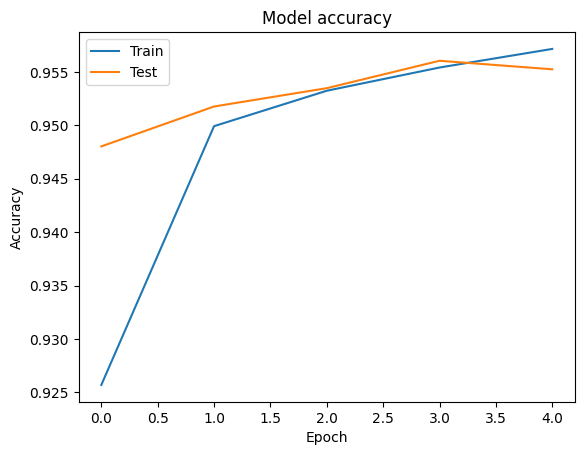

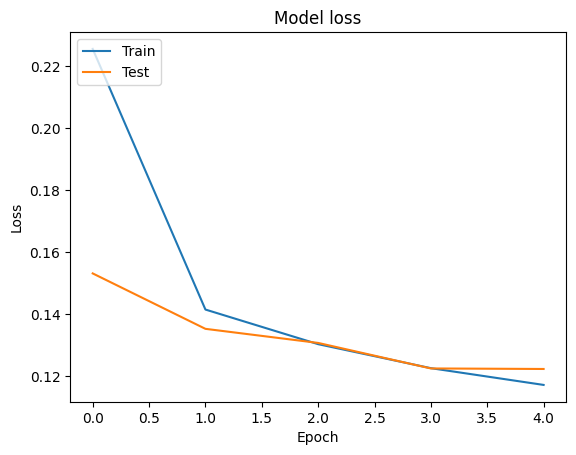

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Prediction

We can get the predictions for the validation data and check the confusion matrix to see the model's performance for each of the 5 classes. Because `tf.keras.Model.predict` method returns an n-d array for probabilities for each class, they can be converted to class labels using `np.argmax`.

In [21]:
y_pred = model.predict(validation_data)

  1/294 [..............................] - ETA: 41s

  5/294 [..............................] - ETA: 4s 

  9/294 [..............................] - ETA: 4s

 13/294 [>.............................] - ETA: 4s

 17/294 [>.............................] - ETA: 4s

 21/294 [=>............................] - ETA: 4s

 25/294 [=>............................] - ETA: 4s

 29/294 [=>............................] - ETA: 3s

 33/294 [==>...........................] - ETA: 3s

 37/294 [==>...........................] - ETA: 3s

 41/294 [===>..........................] - ETA: 3s

 45/294 [===>..........................] - ETA: 3s

 49/294 [====>.........................] - ETA: 3s

 53/294 [====>.........................] - ETA: 3s

 57/294 [====>.........................] - ETA: 3s

 61/294 [=====>........................] - ETA: 3s

 65/294 [=====>........................] - ETA: 3s

 69/294 [======>.......................] - ETA: 3s

 73/294 [======>.......................] - ETA: 3s

 77/294 [======>.......................] - ETA: 3s

 81/294 [=======>......................] - ETA: 3s

 85/294 [=======>......................] - ETA: 3s

 89/294 [========>.....................] - ETA: 3s

 93/294 [========>.....................] - ETA: 2s

 97/294 [========>.....................] - ETA: 2s

101/294 [=========>....................] - ETA: 2s

105/294 [=========>....................] - ETA: 2s

109/294 [==========>...................] - ETA: 2s

113/294 [==========>...................] - ETA: 2s

117/294 [==========>...................] - ETA: 2s

121/294 [===========>..................] - ETA: 2s

125/294 [===========>..................] - ETA: 2s

129/294 [============>.................] - ETA: 2s

133/294 [============>.................] - ETA: 2s

137/294 [============>.................] - ETA: 2s

141/294 [=============>................] - ETA: 2s

145/294 [=============>................] - ETA: 2s

149/294 [==============>...............] - ETA: 2s

153/294 [==============>...............] - ETA: 2s

157/294 [===============>..............] - ETA: 2s

161/294 [===============>..............] - ETA: 1s

165/294 [===============>..............] - ETA: 1s

169/294 [================>.............] - ETA: 1s

173/294 [================>.............] - ETA: 1s

177/294 [=================>............] - ETA: 1s

181/294 [=================>............] - ETA: 1s

185/294 [=================>............] - ETA: 1s

189/294 [==================>...........] - ETA: 1s

193/294 [==================>...........] - ETA: 1s

197/294 [===================>..........] - ETA: 1s

201/294 [===================>..........] - ETA: 1s

205/294 [===================>..........] - ETA: 1s

209/294 [====================>.........] - ETA: 1s

213/294 [====================>.........] - ETA: 1s

217/294 [=====================>........] - ETA: 1s

221/294 [=====================>........] - ETA: 1s

225/294 [=====================>........] - ETA: 1s

228/294 [======================>.......] - ETA: 0s

232/294 [======================>.......] - ETA: 0s

236/294 [=======================>......] - ETA: 0s

240/294 [=======================>......] - ETA: 0s

244/294 [=======================>......] - ETA: 0s

248/294 [========================>.....] - ETA: 0s

252/294 [========================>.....] - ETA: 0s

256/294 [=========================>....] - ETA: 0s

260/294 [=========================>....] - ETA: 0s

264/294 [=========================>....] - ETA: 0s

268/294 [==========================>...] - ETA: 0s

272/294 [==========================>...] - ETA: 0s

276/294 [===========================>..] - ETA: 0s

280/294 [===========================>..] - ETA: 0s

284/294 [===========================>..] - ETA: 0s

288/294 [============================>.] - ETA: 0s

292/294 [============================>.] - ETA: 0s

294/294 [==============================] - 5s 15ms/step


In [22]:
y_pred = np.argmax(y_pred, axis=1)

In [23]:
samples = file_paths[0:3]
for i, sample in enumerate(samples):
  f = open(sample)
  text = f.read()
  print(text[0:100])
  print("True Class: ", sample.split("/")[0])
  print("Predicted Class: ", dir_names[y_pred[i]])
  f.close()
  


বিগত কয়েক বছরের ধারাবাহিকতায় এবারও ঢাকা বিশ্ববিদ্যালয়ের চারুকলা অনুষদের বকুলতলায় বর্ষা উৎসবের আয়োজন
True Class:  entertainment
Predicted Class:  state

কুশিয়ারা নদীরক্ষা বাঁধ নির্মাণে গাফিলতির কারণেই সিলেটের ওসমানীনগর উপজেলার ২১টি গ্রাম বন্যার পানিতে 
True Class:  state
Predicted Class:  state

বিশ্বকাপে ব্রাজিলই সবচেয়ে সফল দেশ। সর্বোচ্চ পাঁচবার বিশ্বকাপ শিরোপা জিতেছে সেলেসাওরা। কিন্তু নিজ দে
True Class:  sports
Predicted Class:  state


## Compare Performance

Now we can take the correct labels for the validation data from `labels` and compare them with our predictions to get a [classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html). 

In [24]:
y_true = np.array(labels[train_size:])

In [25]:
print(classification_report(y_true, y_pred, target_names=dir_names))

               precision    recall  f1-score   support

      economy       0.80      0.80      0.80      3897
       sports       0.98      0.99      0.99     10204
entertainment       0.93      0.91      0.92      6256
        state       0.97      0.98      0.97     48512
international       0.95      0.89      0.92      6377

     accuracy                           0.96     75246
    macro avg       0.93      0.91      0.92     75246
 weighted avg       0.96      0.96      0.96     75246



We can also compare our model's performance with the published results obtained in the original [paper](https://www.researchgate.net/publication/328214545_BARD_Bangla_Article_Classification_Using_a_New_Comprehensive_Dataset), which had a 0.96 precision .The original authors described many preprocessing steps performed on the dataset, such as dropping punctuations and digits, removing top 25 most frequest stop words. As we can see in the `classification_report`, we also manage to obtain a 0.96 precision and accuracy after training for only 5 epochs without any preprocessing! 

In this example, when we created the Keras layer from our embedding module, we set the parameter`trainable=False`, which means the embedding weights will not be updated during training. Try setting it to `True` to reach around 97% accuracy using this dataset after only 2 epochs. 